<a href="https://colab.research.google.com/github/jenelaineDC/DSML-PROJECTS/blob/main/USD%20RUB%20Forecast/USDRUB_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BACKGROUND

As an immigrant from the Philippines residing in Russia, monitoring the performance of the Russian Ruble is a critical aspect of personal financial planning. Currency volatility—particularly in the USD/RUB exchange rate—has direct implications for savings, investments, and purchasing power. Given recent fluctuations, the decision to hold or convert USD requires a data-informed approach.

The Ruble’s valuation is shaped by a complex interplay of factors, including geopolitical developments, macroeconomic indicators, and commodity market dynamics. For individuals navigating financial decisions in Russia, understanding and anticipating currency movements is not merely academic—it is essential.

While exchange rate forecasting is traditionally the domain of policymakers and institutional investors, it holds equal relevance for individuals seeking to make informed, risk-aware financial choices.

### PROJECT GOALS

The primary objective of this project is to develop a predictive model capable of forecasting the USD/RUB exchange rate. By leveraging time series modeling techniques, the project aims to:
- Capture historical patterns and seasonality in currency movements.
- Incorporate external factors such as holidays, commodities, interest rate and potential lag effects.
- Provide data-driven insights that support financial decision-making under uncertainty.

### SCOPE AND LIMITATION

The project will:
- Utilize historical exchange rate data from 2010 to the present.
- Explore the application of Prophet with additional regressors, holiday/events effect and custom seasonality to improve forecast accuracy.
- Evaluate model performance through residual diagnostics and standard error metrics (MAE, MAPE and RMSE).
- Serve as a personal case study to deepen expertise in time series analysis and applied forecasting.

The project will not:
- Serve as financial advice or provide guaranteed investment outcomes.
- Incorporate all possible macroeconomic, geopolitical, or global financial market factors that may influence the Ruble.
- Attempt to predict rare shocks or black swan events (e.g., sudden sanctions, wars, or global crises)

### DISCLAIMER

This project is conducted for educational and personal financial planning purposes only. The forecasts and analyses presented are not investment recommendations and should not be interpreted as financial advice. All insights are exploratory and intended to demonstrate the application of time series forecasting techniques in a real-world context.

#### SET-UP

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

In [2]:
!pip install yfinance

In [99]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.7 MB/s eta 0:00:00


In [3]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DSML PROJECTS/USD RUB Forecast

/content/drive/MyDrive/DSML PROJECTS/USD RUB Forecast


In [5]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import itertools

In [6]:
import yfinance as yf

In [7]:
# Prophet Library
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.utilities import regressor_coefficients

### DATA DEVELOPMENT PROCESS

#### Data Source

This analysis draws upon multiple datasets relevant to forecasting the USD/RUB exchange rate, with a focus on macroeconomic and geopolitical indicators that influence currency dynamics in Russia:

- **Exchange Rate and Commodities:** Daily historical data for the USD/RUB exchange rate and key commodities—including crude oil, gold, silver, platinum, and palladium—are retrieved using the yfinance Python library. These commodities are selected due to their significant impact on Russia’s export economy and currency valuation.

- **Interest Rate Data:** Official interest rate figures are sourced from the Central Bank of Russia, covering the period from September 17, 2013 to September 8, 2025. This data provides insight into monetary policy decisions that may affect exchange rate behavior.

- **Sanctions Data:** Sanction counts are obtained from Castellum.AI, spanning from February 21, 2022 to September 2025. This dataset reflects the evolving geopolitical landscape and its potential influence on the Ruble’s performance.

##### USD/RUB, Oil and Metals

In [8]:
# Download data from Yahoo Finance
tickers = {
    "USD_RUB": "RUB=X",   # USD/RUB exchange rate
    "gold": "GC=F",       # Gold futures
    "silver": "SI=F",     # Silver futures
    "platinum": "PL=F",   # Platinum futures
    "palladium": "PA=F",  # Palladium futures
    "oil_price": "CL=F"   # Crude Oil futures (WTI)
}

df = yf.download(list(tickers.values()), start="2013-09-17", end = '2025-09-08', interval="1d")["Close"]

# Rename columns to friendly names
df = df.rename(columns={v: k for k, v in tickers.items()})

[*********************100%***********************]  6 of 6 completed


In [9]:
df.head()

Ticker       oil_price         gold   palladium     platinum    USD_RUB  \
Date                                                                      
2013-09-17  105.419998  1309.500000  705.250000  1421.800049  32.284100   
2013-09-18  108.070000  1307.800049  701.450012  1424.599976  32.186600   
2013-09-19  106.389999  1369.400024  736.549988  1472.400024  31.771999   
2013-09-20  104.680000  1332.500000  720.299988  1432.099976  31.640499   
2013-09-23  103.589996  1326.900024  716.299988  1425.400024  31.837999   

Ticker         silver  
Date                   
2013-09-17  21.735001  
2013-09-18  21.514000  
2013-09-19  23.242001  
2013-09-20  21.875999  
2013-09-23  21.805000

In [10]:
# Replace values for specific dates
print(df.loc[['2016-01-06', '2023-03-16'], 'USD_RUB'])
df.loc['2016-01-06', 'USD_RUB'] = 74.75
df.loc['2023-03-16', 'USD_RUB'] = 76.91
print(df.loc[['2016-01-06', '2023-03-16'], 'USD_RUB'])


# Correcting the values for dates Jan 6 2016 and March 16 2023.
# This was identified based on the EDA and initial checking of deviations on CV

Date
2016-01-06    0.7162
2023-03-16    5.0000
Name: USD_RUB, dtype: float64
Date
2016-01-06    74.75
2023-03-16    76.91
Name: USD_RUB, dtype: float64


In [11]:
# Create Dataframe for Prophet
df_prophet = df.reset_index()
df_prophet = df_prophet.rename(columns={"Date": "ds",
                                        "USD_RUB" : "y"})

# Set Frequency to Daily and Forward Fill Missing Values
df_prophet = (
    df_prophet.set_index("ds")
    .resample("D")
    .ffill()
    .reset_index()
)

##### Interest Rate

In [12]:
df_rate =  pd.read_csv("interest_rate.csv")
df_rate['ds'] = pd.to_datetime(df_rate['ds'], errors='coerce')
df_rate.head()

ds  interest_rate
0 2013-09-17            5.5
1 2013-09-18            5.5
2 2013-09-19            5.5
3 2013-09-20            5.5
4 2013-09-23            5.5

In [13]:
# Fill missing values safely without chained assignment
df_rate['interest_rate'] = (df_rate['interest_rate']
                            .fillna(method='ffill')   # forward-fill between meetings
                            .fillna(method='bfill')   # backfill for early years (pre-2013)
                            )


In [14]:
# Merge to df_prophet
df_prophet = pd.merge(df_prophet, df_rate, on='ds', how='left')
df_prophet.head()

ds   oil_price         gold   palladium     platinum          y  \
0 2013-09-17  105.419998  1309.500000  705.250000  1421.800049  32.284100   
1 2013-09-18  108.070000  1307.800049  701.450012  1424.599976  32.186600   
2 2013-09-19  106.389999  1369.400024  736.549988  1472.400024  31.771999   
3 2013-09-20  104.680000  1332.500000  720.299988  1432.099976  31.640499   
4 2013-09-21  104.680000  1332.500000  720.299988  1432.099976  31.640499   

      silver  interest_rate  
0  21.735001            5.5  
1  21.514000            5.5  
2  23.242001            5.5  
3  21.875999            5.5  
4  21.875999            NaN

##### Sanction Count

In [15]:
# Load and prepare sanctions data
sanctions_data = pd.read_csv("sanctions_data.csv")
sanctions_data = sanctions_data.rename(columns = {"X.1": "ds",
                                                 "Unnamed: 1" : "sanctions_count"})
sanctions_data["ds"] = pd.to_datetime(sanctions_data["ds"], errors="coerce")

sanctions_data = (
    sanctions_data.set_index("ds")
    .resample("D")
    .ffill()
    .reset_index()
)

sanctions_data.head()

ds  sanctions_count
0 2022-02-21             2613
1 2022-02-22             2687
2 2022-02-23             2687
3 2022-02-24             3596
4 2022-02-25             4777

In [16]:
# Merge Cummulative Sanctions Data to df_prophet
df_prophet = df_prophet.merge(sanctions_data, on="ds", how="left")


In [17]:
df_prophet.head()

ds   oil_price         gold   palladium     platinum          y  \
0 2013-09-17  105.419998  1309.500000  705.250000  1421.800049  32.284100   
1 2013-09-18  108.070000  1307.800049  701.450012  1424.599976  32.186600   
2 2013-09-19  106.389999  1369.400024  736.549988  1472.400024  31.771999   
3 2013-09-20  104.680000  1332.500000  720.299988  1432.099976  31.640499   
4 2013-09-21  104.680000  1332.500000  720.299988  1432.099976  31.640499   

      silver  interest_rate  sanctions_count  
0  21.735001            5.5              NaN  
1  21.514000            5.5              NaN  
2  23.242001            5.5              NaN  
3  21.875999            5.5              NaN  
4  21.875999            NaN              NaN

In [18]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4372 entries, 0 to 4371
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ds               4372 non-null   datetime64[ns]
 1   oil_price        4221 non-null   float64       
 2   gold             4220 non-null   float64       
 3   palladium        4214 non-null   float64       
 4   platinum         4217 non-null   float64       
 5   y                4367 non-null   float64       
 6   silver           4220 non-null   float64       
 7   interest_rate    2998 non-null   float64       
 8   sanctions_count  1269 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 307.5 KB


In [19]:
# Handle missing values
df_prophet = df_prophet.ffill().bfill()

In [20]:
# Check missing values
df_prophet.isna().sum().sort_values(ascending=False)

ds                 0
oil_price          0
gold               0
palladium          0
platinum           0
y                  0
silver             0
interest_rate      0
sanctions_count    0
dtype: int64

#### EDA

##### Seasonality Plot

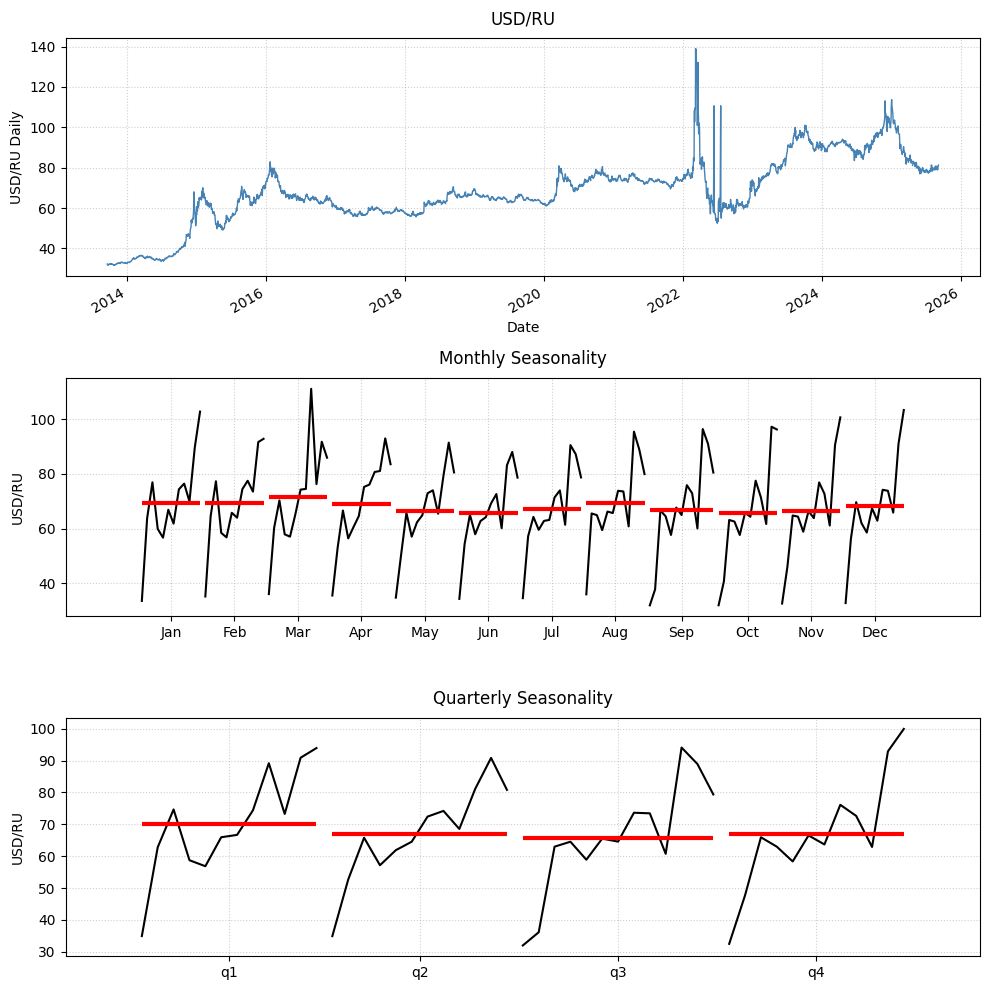

In [21]:
# Create figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)  # Adjust spacing between subplots

# Daily Plot
df['USD_RUB'].plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('USD/RU', fontsize=12, pad=10)
ax1.set_ylabel('USD/RU Daily', fontsize=10)
ax1.grid(True, linestyle=':', alpha=0.6)

# Monthly Seasonality Plot
month_plot(df['USD_RUB'].resample('ME').mean(), ylabel='USD/RU', ax=ax2)
ax2.set_title('Monthly Seasonality', fontsize=12, pad=10)
ax2.set_ylabel('USD/RU', fontsize=10)
ax2.grid(True, linestyle=':', alpha=0.6)

# Quarterly Seasonality Plot
quarter_plot(df['USD_RUB'].resample('QE').mean(), ylabel='Demand', ax=ax3)
ax3.set_title('Quarterly Seasonality', fontsize=12, pad=10)
ax3.set_ylabel('USD/RU', fontsize=10)
ax3.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

##### Ukraine War and Sanctions Count

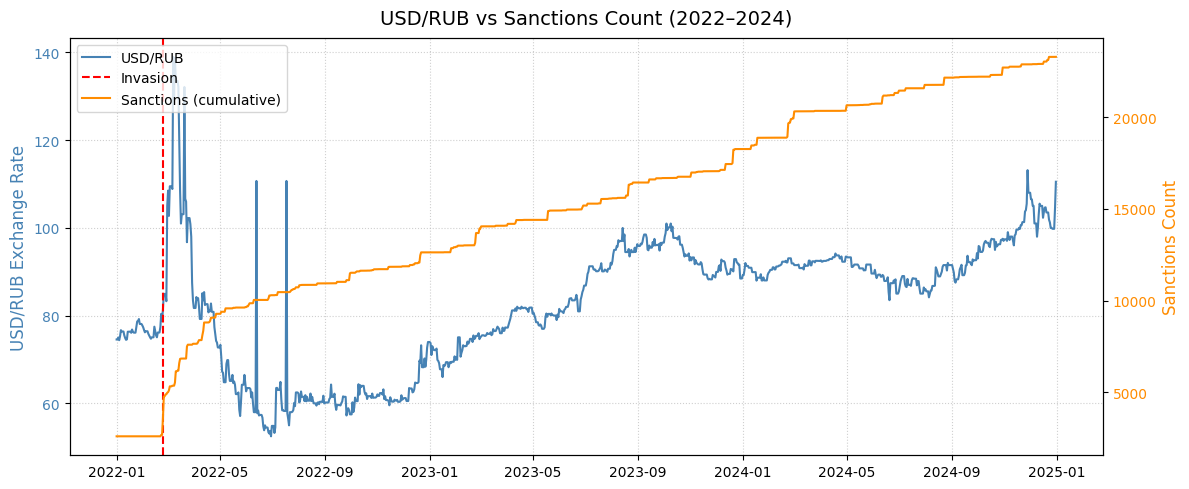

In [22]:
# Filter data for 2022 to 2024
mask = (df_prophet['ds'] >= '2022-01-01') & (df_prophet['ds'] <= '2024-12-31')
df_zoom = df_prophet.loc[mask]

# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot USD/RUB on primary y-axis
ax1.plot(df_zoom['ds'], df_zoom['y'], color='steelblue', label='USD/RUB')
ax1.set_ylabel('USD/RUB Exchange Rate', color='steelblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, linestyle=':', alpha=0.6)

# Add invasion marker
ax1.axvline(pd.to_datetime('2022-02-24'), color='red', linestyle='--', label='Invasion')

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df_zoom['ds'], df_zoom['sanctions_count'], color='darkorange', label='Sanctions (cumulative)')
ax2.set_ylabel('Sanctions Count', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title and layout
ax1.set_title('USD/RUB vs Sanctions Count (2022–2024)', fontsize=14, pad=10)
plt.tight_layout()
plt.show()

In [23]:
# Define Pre and Postwar Event
# Define war cutoff date
cutoff_date = pd.to_datetime("2022-02-24")

# Make sure flags are boolean
df_prophet['pre_war'] = (df_prophet['ds'] < cutoff_date).astype(bool)
df_prophet['post_war'] = (df_prophet['ds'] >= cutoff_date).astype(bool)

##### Partial Autocorrelation Plot

<Figure size 1200x600 with 0 Axes>

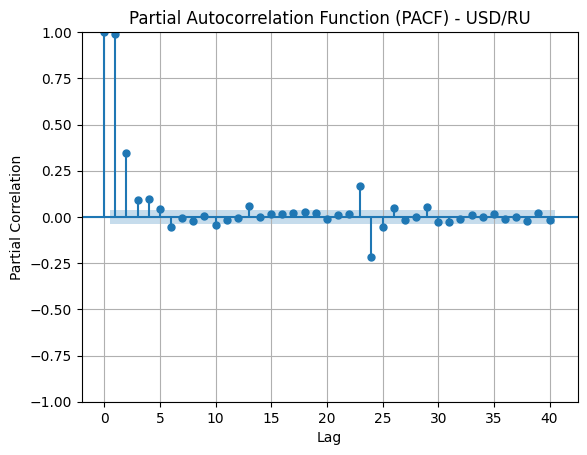

In [24]:
df = df.dropna()

# Create PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(df['USD_RUB'], lags=40, alpha=0.05, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) - USD/RU')
plt.xlabel('Lag')
plt.ylabel('Partial Correlation')
plt.grid(True)
plt.show()

In [25]:
# Create Lagged Values
for lag in [1,2,3,4,5,6,13]:
  df_prophet[f'y_lag_{lag}'] = df_prophet['y'].shift(lag)

df_prophet = df_prophet.dropna()
df_prophet.head()

ds   oil_price         gold   palladium     platinum          y  \
13 2013-09-30  102.330002  1326.500000  726.150024  1408.099976  32.342098   
14 2013-10-01  102.040001  1286.000000  717.900024  1381.699951  32.402599   
15 2013-10-02  104.099998  1320.599976  720.200012  1389.800049  32.230400   
16 2013-10-03  103.309998  1317.400024  699.200012  1369.500000  32.097000   
17 2013-10-04  103.839996  1309.699951  700.950012  1384.699951  32.142899   

       silver  interest_rate  sanctions_count  pre_war  post_war    y_lag_1  \
13  21.656000            5.5           2613.0     True     False  32.279202   
14  21.124001            5.5           2613.0     True     False  32.342098   
15  21.846001            5.5           2613.0     True     False  32.402599   
16  21.739000            5.5           2613.0     True     False  32.230400   
17  21.705000            5.5           2613.0     True     False  32.097000   

      y_lag_2    y_lag_3    y_lag_4    y_lag_5    y_lag_6   y_lag_13  
13  32.279202  32.279202  32.078300  31.841999  31.789700  32.284100  
14  32.279202  32.279202  32.279202  32.078300  31.841999  32.186600  
15  32.342098  32.279202  32.279202  32.279202  32.078300  31.771999  
16  32.402599  32.342098  32.279202  32.279202  32.279202  31.640499  
17  32.230400  32.402599  32.342098  32.279202  32.279202  31.640499

#### Model Development

To ensure a rigorous modeling approach, I implemented the following workflow:

1. Data Splitting (Train/Test).
The data is split to training from year 2010 to 2024 while testing will be from the start of 2025 to present.
2. Model Training and Testing
All candidate models were trained on the same training set. The selected model will be tested and the evaluation metric to be used are MAE, MAPE and RMSE.
3. Cross Validation and Hyperparameter tuning.
The selected model will be tuned and cross validated leading to our champion model. For cross validation, we choose rolling window with an initial training data of 2 years, period of 30 days and forecast horizon of 90 days.

##### Data Splitting

In [26]:
# Train Test Split
train = df_prophet[df_prophet['ds'].dt.year <= 2024]
test = df_prophet[df_prophet['ds'].dt.year >= 2025]

#Forecast_days
forecast_days = len(test)


print(df_prophet.shape)
print(train.shape)
print(test.shape)
print(forecast_days)

(4359, 18)
(4111, 18)
(248, 18)
248


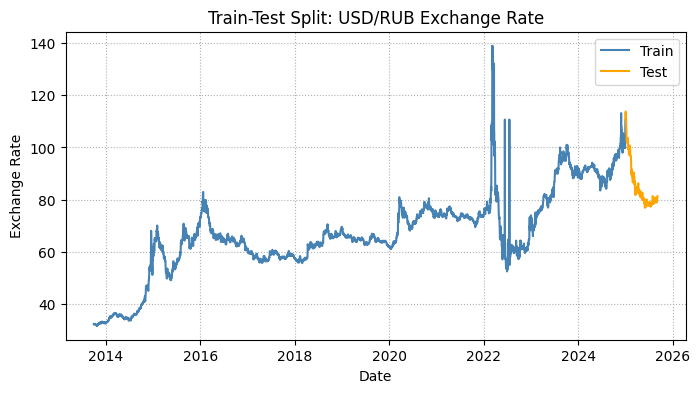

In [27]:
# Plot Train Test Split
plt.figure(figsize=(8, 4))
plt.plot(train['ds'], train['y'], label='Train', color='steelblue')
plt.plot(test['ds'], test['y'], label='Test', color='orange')
plt.title('Train-Test Split: USD/RUB Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

##### Prophet Model

The objective of this section is to develop a series of Prophet models with varying levels of complexity and compare their performance on the test set using Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Mean Squared Error (MSE). This stepwise approach allows us to assess the incremental value of incorporating holidays, events, custom seasonalities, and external regressors into the forecasting process.

The models considered are as follows:

- M1: Baseline Prophet Model
A simple Prophet model including only trend and seasonality components. This serves as the benchmark for comparison.

- M2: Prophet with Holidays and Major Events
Extends the baseline model by incorporating key global and domestic shocks, including the 2022 Ukraine invasion, the 2020 COVID-19 outbreak, the 2014 Crimea invasion, and the 2020 OPEC oil deal. This model allows us to evaluate the effect of exogenous shocks on USD/RUB dynamics.

- M3: Prophet with Holidays, Events, and Sanctions
Builds on M2 by adding sanctions-related events as external factors, acknowledging their role in shaping the Ruble’s performance during periods of geopolitical stress.

- M4: Prophet with Custom Seasonality
Expands M3 by introducing custom seasonal patterns, specifically targeting shifts in behavior before and after the 2022 Ukraine invasion. This model tests whether regime shifts in the series can be better captured through tailored seasonality.

- M5: Prophet with Economic Regressors
Incorporates macroeconomic and commodity-related regressors, including sanctions count, interest rates, oil prices, and precious metals, to account for broader economic drivers influencing currency fluctuations.

- M6: Prophet with Lagged Values
Adds autoregressive elements by including lagged values of the target variable as regressors, enabling the model to capture short-term dependencies and momentum effects in the USD/RUB exchange rate.

In [28]:
def evaluate_forecast(forecast, test, forecast_days, model_name):
    """
    Evaluate Prophet forecast using MAE, MAPE, and MSE.
    Returns a dictionary for easy DataFrame creation.
    """
    y_pred = forecast['yhat'].values[-forecast_days:]
    y_true = test['y'].values[-len(y_pred):]

    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mse = mean_squared_error(y_true, y_pred)

    return {
        "Model": model_name,
        "MAE": mae,
        "MAPE": mape,
        "MSE": mse
    }


###### M1: Baseline

In [29]:
# Building the Prophet model
m1 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add monthly seasonality
m1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m1.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/hy8487_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/9gc7mdd0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91718', 'data', 'file=/tmp/tmpic4nhgzq/hy8487_4.json', 'init=/tmp/tmpic4nhgzq/9gc7mdd0.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modell28u79i6/prophet_model-20250919072351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:23:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


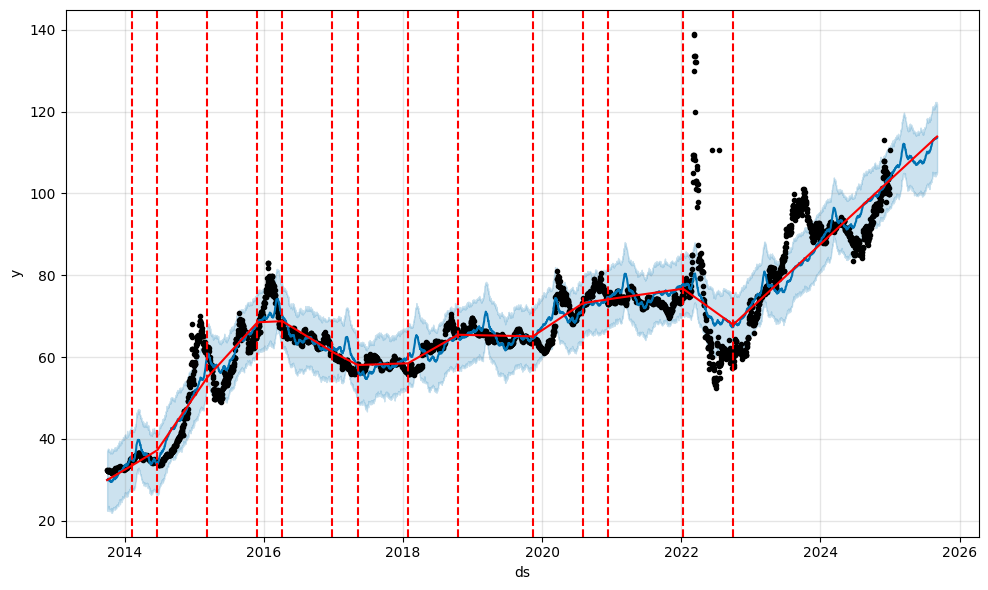

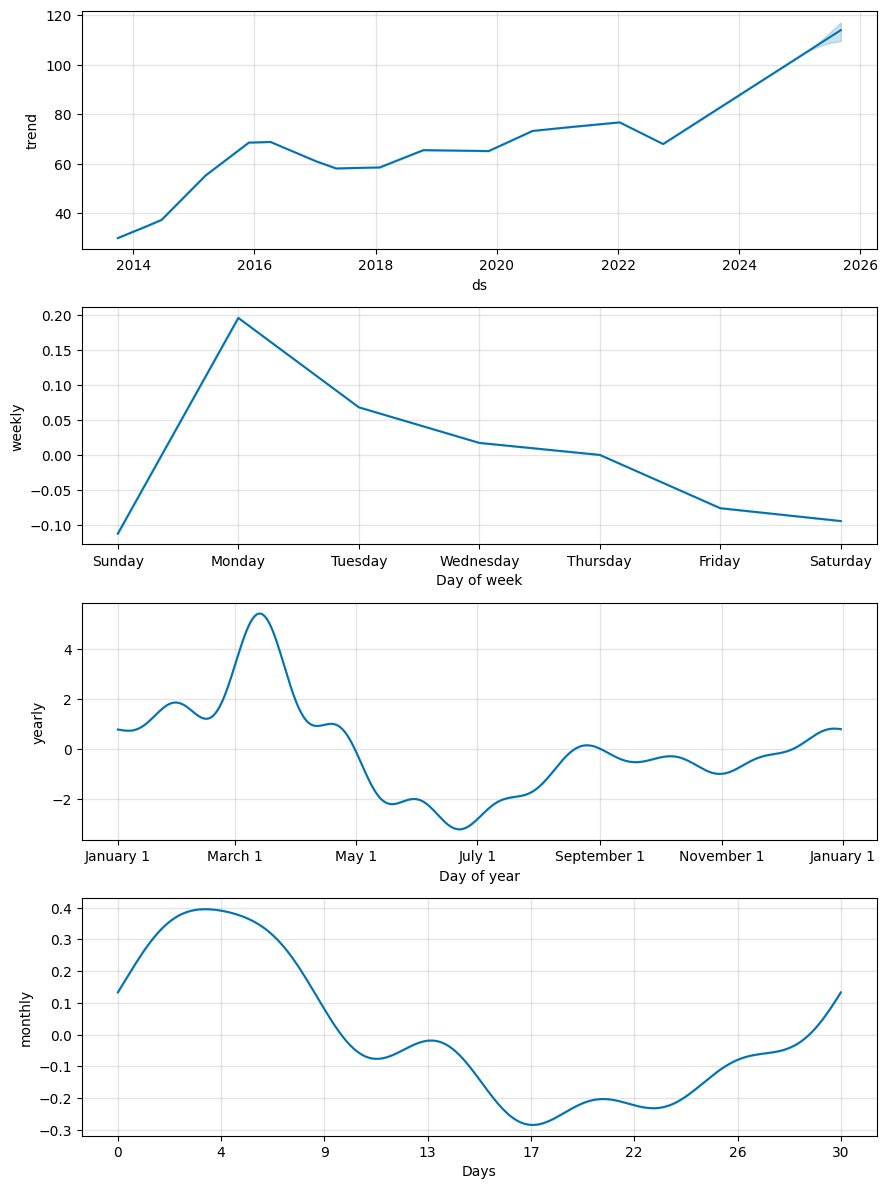

In [30]:
# Create future dataframe
future = m1.make_future_dataframe(periods=forecast_days)

# Make predictions
forecast_m1 = m1.predict(future)

# Plot forecast
fig = m1.plot(forecast_m1)
a = add_changepoints_to_plot(fig.gca(), m1, forecast_m1)

fig = m1.plot_components(forecast_m1)

In [31]:
m1_result = evaluate_forecast(forecast_m1, test, forecast_days, model_name="m1")
m1_result

{'Model': 'm1',
 'MAE': 23.819304192578834,
 'MAPE': np.float64(29.091363073493476),
 'MSE': 651.2631699972909}

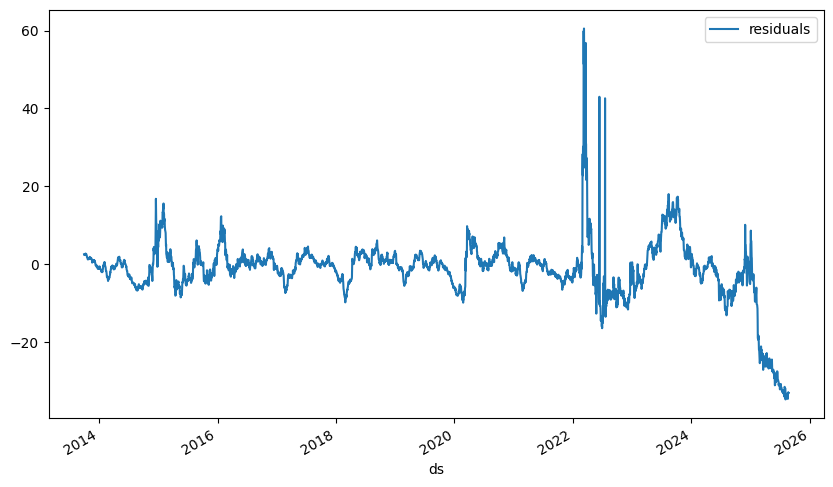

In [32]:
# plotting the residuals
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast_m1["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

###### M2: Prophet with Holidays and Major Events

In [33]:
# Custom Holiday
crimea = pd.DataFrame({'holiday': 'Crimea',
                     'ds': pd.to_datetime(['2014-03-18']),
                             'lower_window': -3,
                             'upper_window': 14})

covid = pd.DataFrame({'holiday': 'Covid',
                     'ds': pd.to_datetime(['2020-03-11']),
                             'lower_window': -5,
                             'upper_window': 14})

ukraine = pd.DataFrame({'holiday': 'Ukraine',
                     'ds': pd.to_datetime(['2022-02-24']),
                             'lower_window': -5,
                             'upper_window': 14})

opec = pd.DataFrame({'holiday': ['Opec_collapse', 'Opec_deal'],
                     'ds': pd.to_datetime(['2020-03-08', '2020-04-12']),
                     'lower_window': [-2, -2],
                     'upper_window': [14, 14]})

news = pd.DataFrame({'holiday': 'news',
                     'ds': pd.to_datetime(['2022-09-29', '2022-06-30', '2022-07-21', '2022-07-03']),
                             'lower_window': -1,
                             'upper_window': 3})

In [34]:
custom_holidays = pd.concat([crimea, covid, ukraine, opec], ignore_index=True)

In [35]:
# Building the Prophet model
m2 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m2.add_country_holidays(country_name='RU')

# Add monthly seasonality
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m2.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/96rhc1_q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/5hwcxges.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79168', 'data', 'file=/tmp/tmpic4nhgzq/96rhc1_q.json', 'init=/tmp/tmpic4nhgzq/5hwcxges.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modeljzsbcn6x/prophet_model-20250919072359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:23:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:24:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


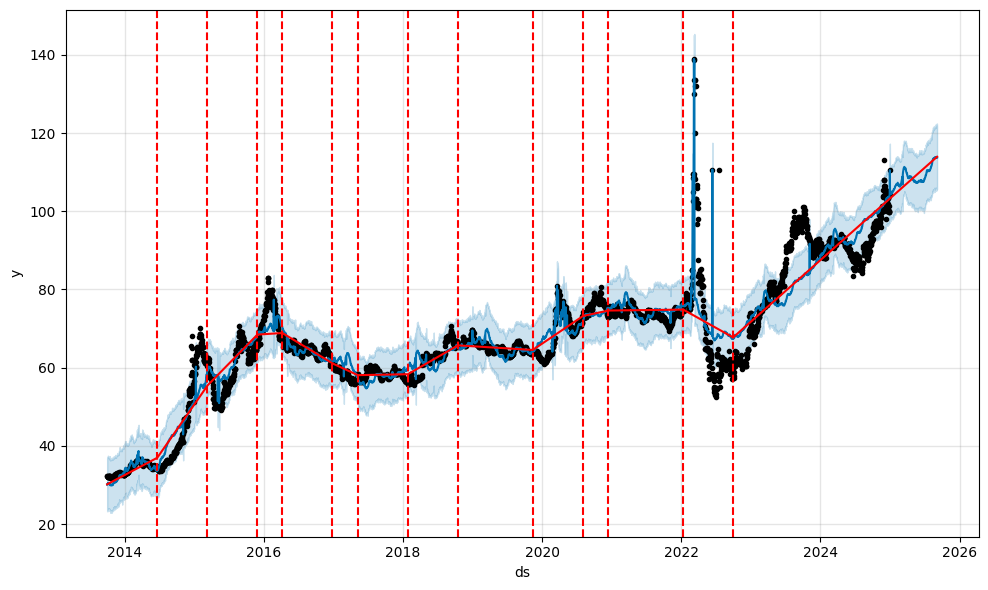

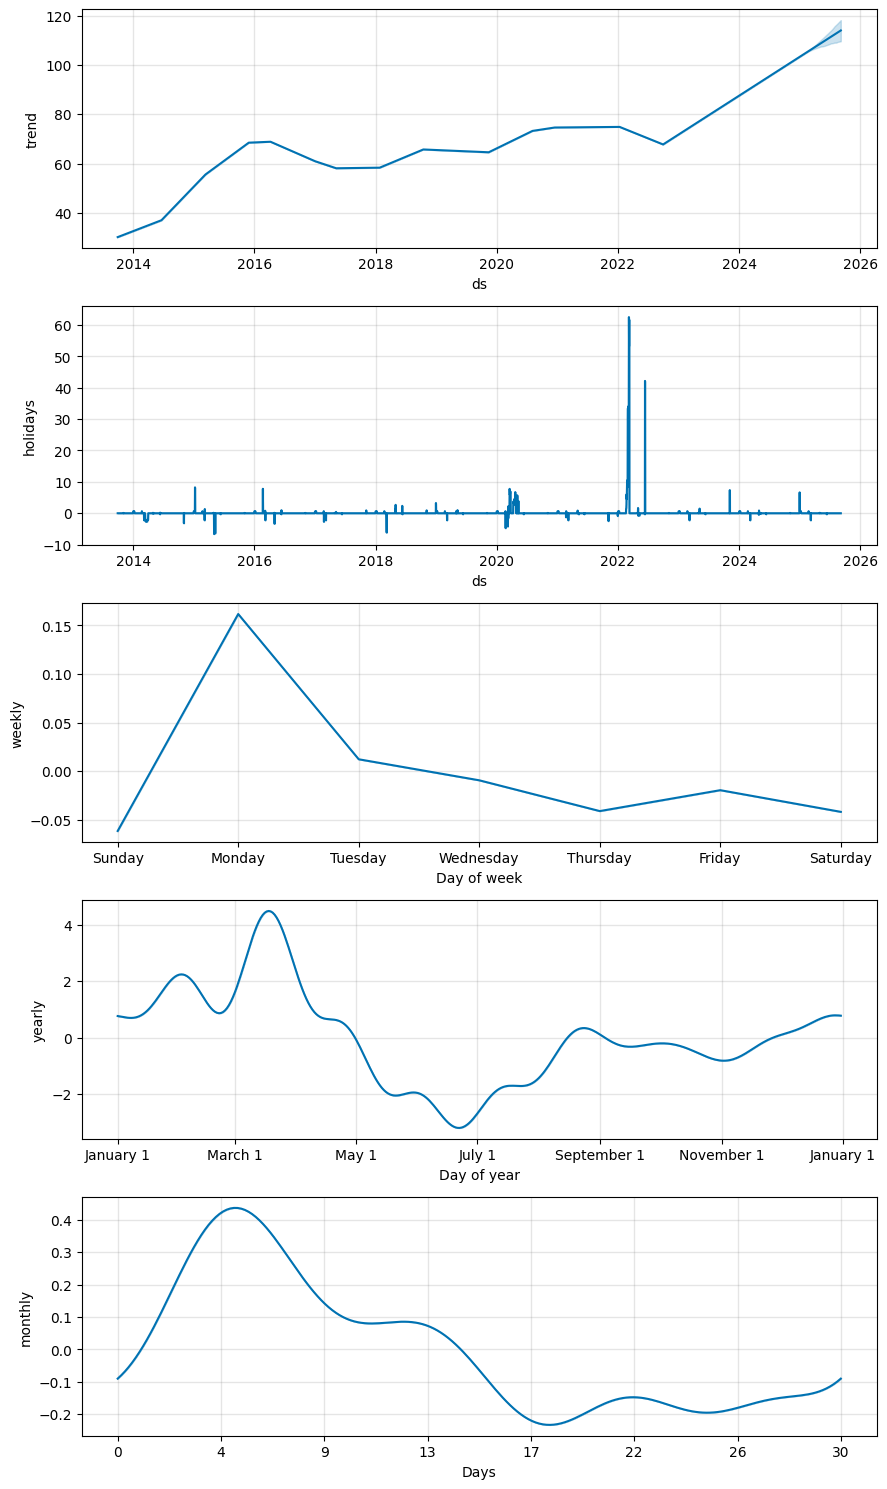

In [36]:
# Create future dataframe
future = m2.make_future_dataframe(periods=forecast_days)

# Make predictions
forecast_m2 = m2.predict(future)

# Plot forecast
fig = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig.gca(), m2, forecast_m2)

fig = m2.plot_components(forecast_m2)

In [37]:
m2_result = evaluate_forecast(forecast_m2, test, forecast_days, model_name="m2")
m2_result

{'Model': 'm2',
 'MAE': 23.763557390638297,
 'MAPE': np.float64(29.03893701114305),
 'MSE': 650.3621918985166}

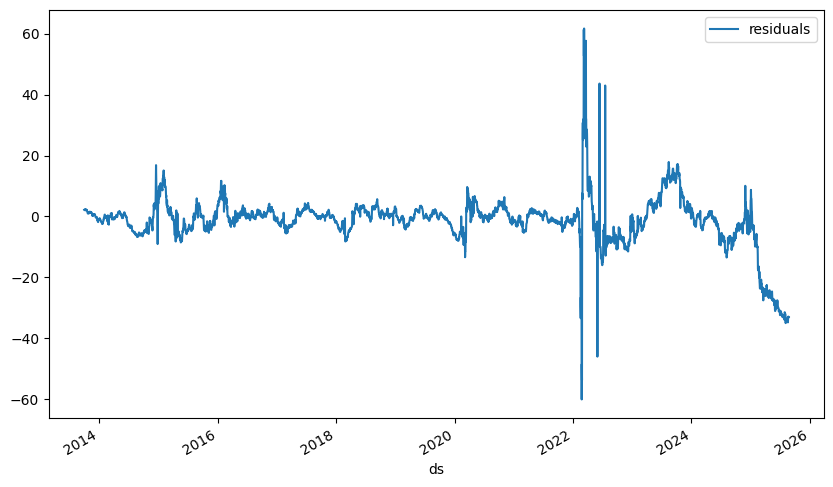

In [38]:
# plotting the residuals
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast_m2["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

###### M3: Prophet with Holidays, Events, and Sanctions

In [39]:
# Load and prepare sanctions data
sanc_df = pd.read_csv("sanctions_data.csv")
sanc_df = sanc_df.rename(columns={"X.1": "ds", "Unnamed: 1": "sanctions_count"})
sanc_df["ds"] = pd.to_datetime(sanc_df["ds"], errors="coerce")
sanc_df = sanc_df.dropna().sort_values('ds')

# Calculate daily sanction changes (new sanctions added each day)
sanc_df['daily_change'] = sanc_df['sanctions_count'].diff().fillna(0)

# Identify sudden sanction DROPS (negative changes)
# We'll look for significant negative changes
sanc_df['change_pct'] = sanc_df['daily_change'].pct_change()
mean_change = sanc_df['daily_change'].mean()
std_change = sanc_df['daily_change'].std()

# Define sudden drops as changes more than 2 standard deviations below mean
drop_threshold = mean_change - 1.5 * std_change
sudden_drops = sanc_df[sanc_df['daily_change'] < drop_threshold].copy()

print(f"Found {len(sudden_drops)} sudden sanction drop events")

# Create events dataframe for Prophet (as holidays)
sanction_drop_events = pd.DataFrame({
    'holiday': 'sanction_drop',
    'ds': sudden_drops['ds'],
    'lower_window': -1,  # Include day before and after
    'upper_window': 1
})

# Also identify sudden sanction SPIKEs (positive changes) if needed
spike_threshold = mean_change + 1.5 * std_change
sudden_spikes = sanc_df[sanc_df['daily_change'] > spike_threshold].copy()

sanction_spike_events = pd.DataFrame({
    'holiday': 'sanction_spike',
    'ds': sudden_spikes['ds'],
    'lower_window': -1,
    'upper_window': 3
})

# Combine both events
all_sanction_events = pd.concat([sanction_drop_events, sanction_spike_events])

Found 0 sudden sanction drop events


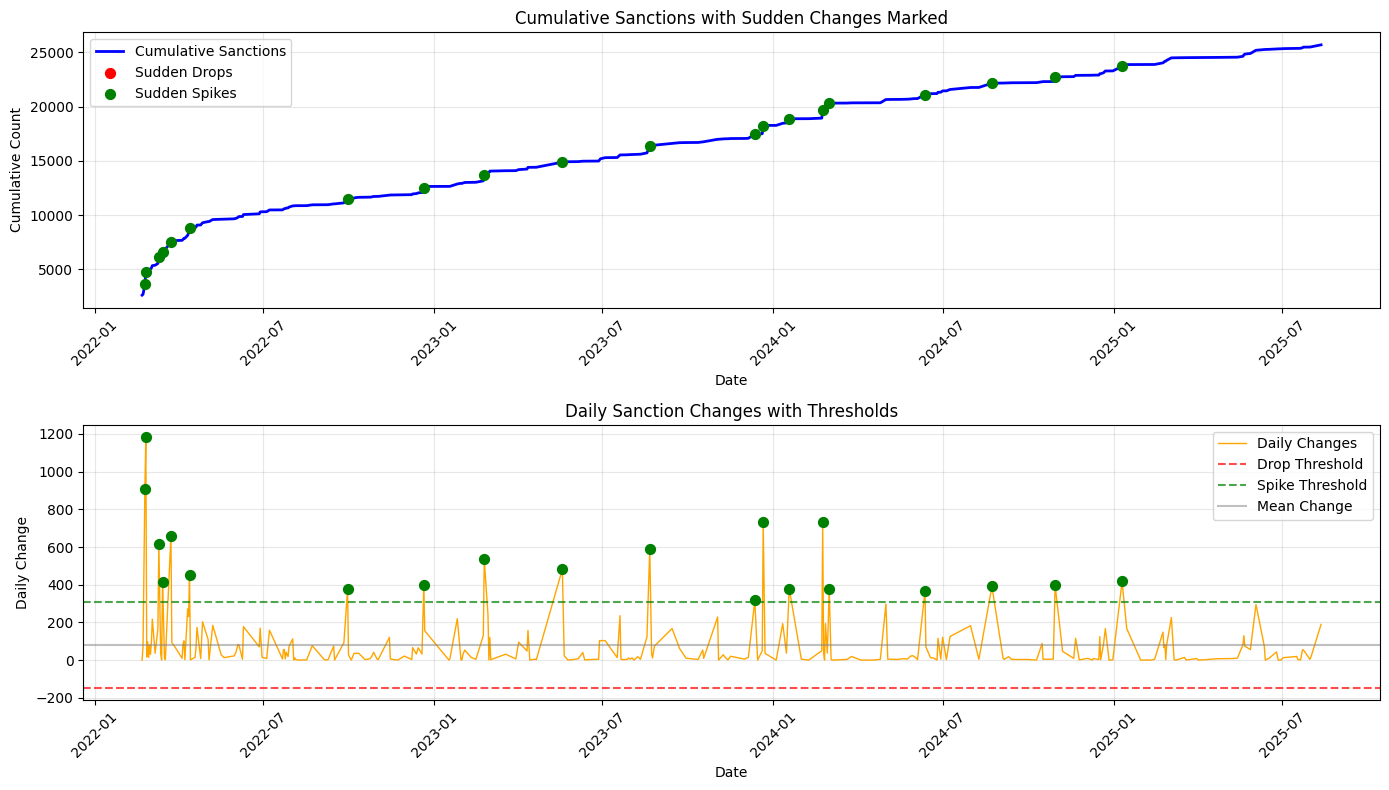


Sudden sanction DROP events:
Empty DataFrame
Columns: [ds, sanctions_count, daily_change]
Index: []

Sudden sanction SPIKE events:
        ds  sanctions_count  daily_change
2022-02-24             3596         909.0
2022-02-25             4777        1181.0
2022-03-11             6155         617.0
2022-03-15             6602         412.0
2022-03-24             7510         660.0
2022-04-13             8813         454.0
2022-09-30            11495         375.0
2022-12-21            12478         401.0
2023-02-24            13686         534.0
2023-05-19            14887         482.0
2023-08-21            16320         589.0
2023-12-12            17446         317.0
2023-12-21            18227         730.0
2024-01-18            18876         380.0
2024-02-23            19663         730.0
2024-03-01            20312         380.0
2024-06-12            21106         367.0
2024-08-23            22154         391.0
2024-10-30            22704         397.0
2025-01-10            23704 

In [40]:
# Plot the sanctions data with events marked
plt.figure(figsize=(14, 8))

# Plot cumulative sanctions
plt.subplot(2, 1, 1)
plt.plot(sanc_df['ds'], sanc_df['sanctions_count'], 'b-', linewidth=2, label='Cumulative Sanctions')
plt.scatter(sudden_drops['ds'], sudden_drops['sanctions_count'], color='red', s=50,
           label='Sudden Drops', zorder=5)
plt.scatter(sudden_spikes['ds'], sudden_spikes['sanctions_count'], color='green', s=50,
           label='Sudden Spikes', zorder=5)
plt.title('Cumulative Sanctions with Sudden Changes Marked')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot daily changes
plt.subplot(2, 1, 2)
plt.plot(sanc_df['ds'], sanc_df['daily_change'], 'orange', linewidth=1, label='Daily Changes')
plt.axhline(y=drop_threshold, color='red', linestyle='--', alpha=0.7, label='Drop Threshold')
plt.axhline(y=spike_threshold, color='green', linestyle='--', alpha=0.7, label='Spike Threshold')
plt.axhline(y=mean_change, color='gray', linestyle='-', alpha=0.5, label='Mean Change')
plt.scatter(sudden_drops['ds'], sudden_drops['daily_change'], color='red', s=50, zorder=5)
plt.scatter(sudden_spikes['ds'], sudden_spikes['daily_change'], color='green', s=50, zorder=5)
plt.title('Daily Sanction Changes with Thresholds')
plt.xlabel('Date')
plt.ylabel('Daily Change')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show the events in a table
print("\nSudden sanction DROP events:")
print(sudden_drops[['ds', 'sanctions_count', 'daily_change']].to_string(index=False))

print("\nSudden sanction SPIKE events:")
print(sudden_spikes[['ds', 'sanctions_count', 'daily_change']].to_string(index=False))

In [41]:
custom_holidays2 = pd.concat([crimea, covid, ukraine, opec, news, all_sanction_events], ignore_index=True)

In [42]:
# Building the Prophet model
m3 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=20, # Control flexibility in detecting trend changes
)

# Add built in country holidays
m3.add_country_holidays(country_name='RU')

# Add monthly seasonality
m3.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m3.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/ghc58rfo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/yl4wl1as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59756', 'data', 'file=/tmp/tmpic4nhgzq/ghc58rfo.json', 'init=/tmp/tmpic4nhgzq/yl4wl1as.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modeljtd_l6vz/prophet_model-20250919072410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:24:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


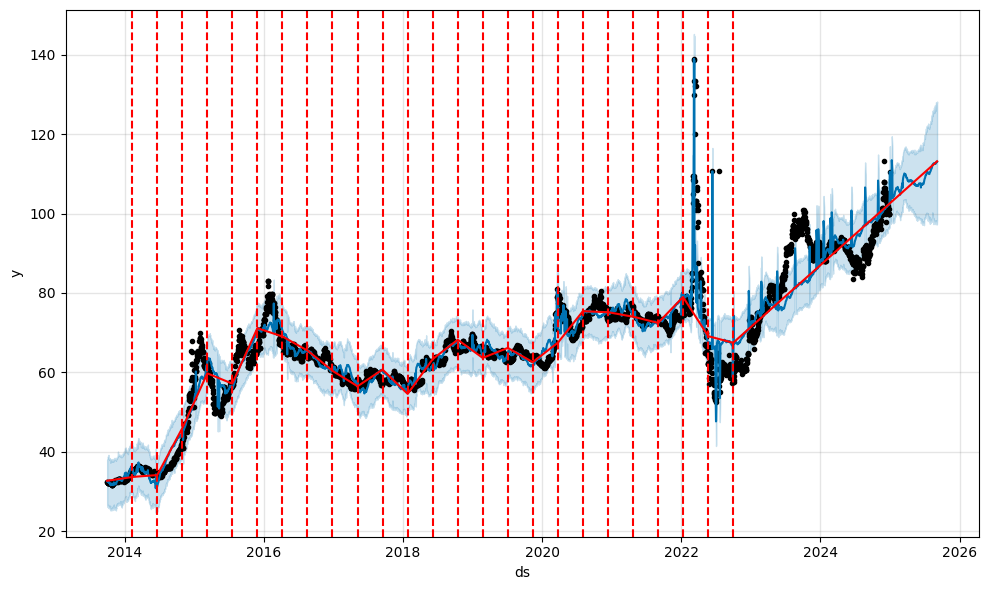

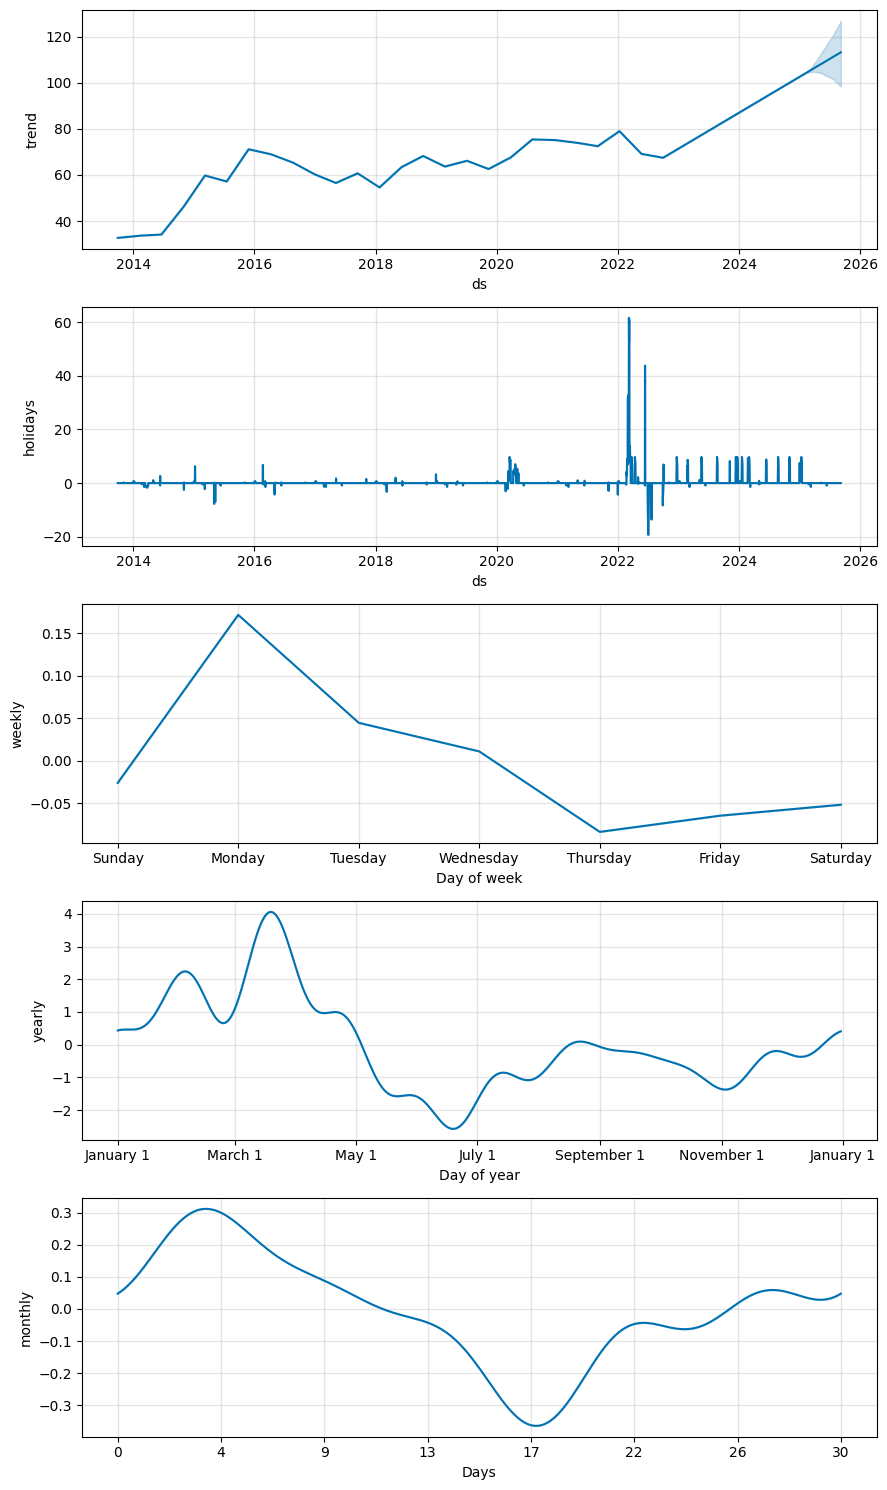

In [43]:
# Create future dataframe
future = m3.make_future_dataframe(periods=forecast_days)

# Make predictions
forecast_m3 = m3.predict(future)

# Plot forecast
fig = m3.plot(forecast_m3)
a = add_changepoints_to_plot(fig.gca(), m3, forecast_m3)

fig = m3.plot_components(forecast_m3)

In [44]:
m3_result = evaluate_forecast(forecast_m3, test, forecast_days, model_name="m3")
m3_result

{'Model': 'm3',
 'MAE': 23.413410222035736,
 'MAPE': np.float64(28.60116613645957),
 'MSE': 629.7920850671672}

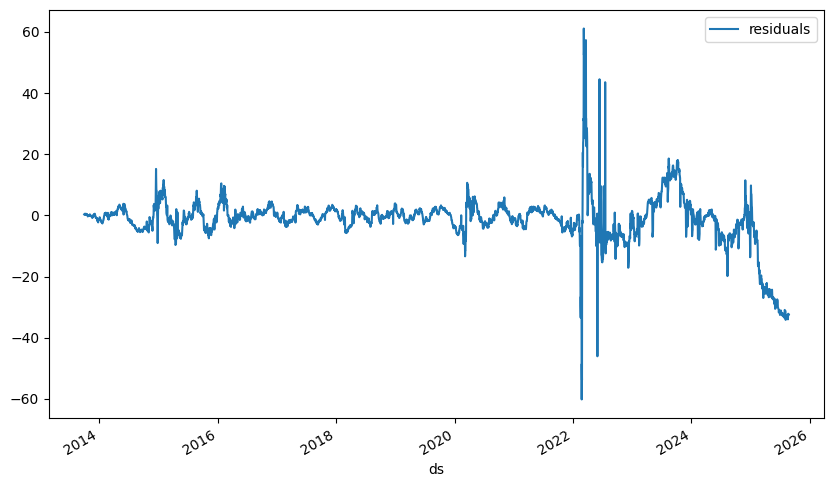

In [45]:
# plotting the residuals
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast_m3["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

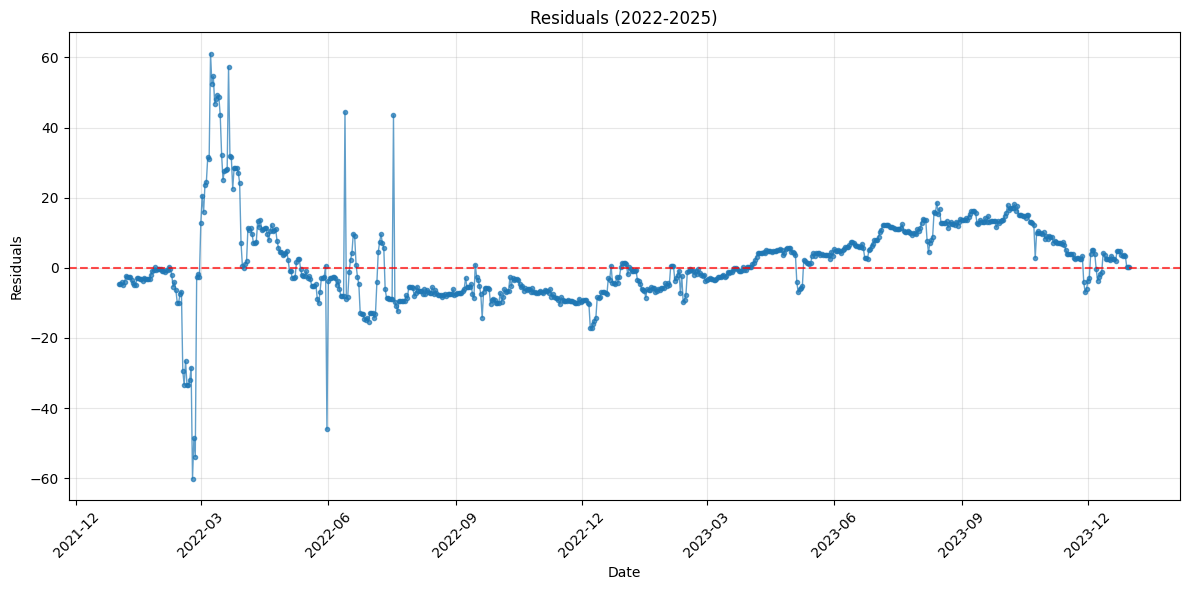

In [46]:
# Filter residuals for 2022-2025 only
df_residuals_2022_2025 = df_residuals[
    (df_residuals['ds'].dt.year >= 2022) &
    (df_residuals['ds'].dt.year <= 2023)
]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_residuals_2022_2025['ds'], df_residuals_2022_2025['residuals'],
         'o-', markersize=3, linewidth=1, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Residuals (2022-2025)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Format x-axis for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

###### M4: Prophet with Custom Seasonality

In [47]:
# Building the Prophet model
m4 = Prophet(
    yearly_seasonality=False,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="multiplicative",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add monthly seasonality
m4.add_seasonality(name='monthly_pre_war', period=30.5, fourier_order=3, condition_name='pre_war')
m4.add_seasonality(name='monthly_post_war', period=30.5, fourier_order=3, condition_name='post_war')

# Custom Yearly Seasonality
m4.add_seasonality(name='yearly_pre_war', period=366, fourier_order=3, condition_name='pre_war')
m4.add_seasonality(name='yearly_post_war',period=366, fourier_order=3, condition_name='post_war')

m4.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/1s3h4lr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/1jbjnxzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60034', 'data', 'file=/tmp/tmpic4nhgzq/1s3h4lr7.json', 'init=/tmp/tmpic4nhgzq/1jbjnxzv.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modelw_mk8qcw/prophet_model-20250919072425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:24:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:24:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


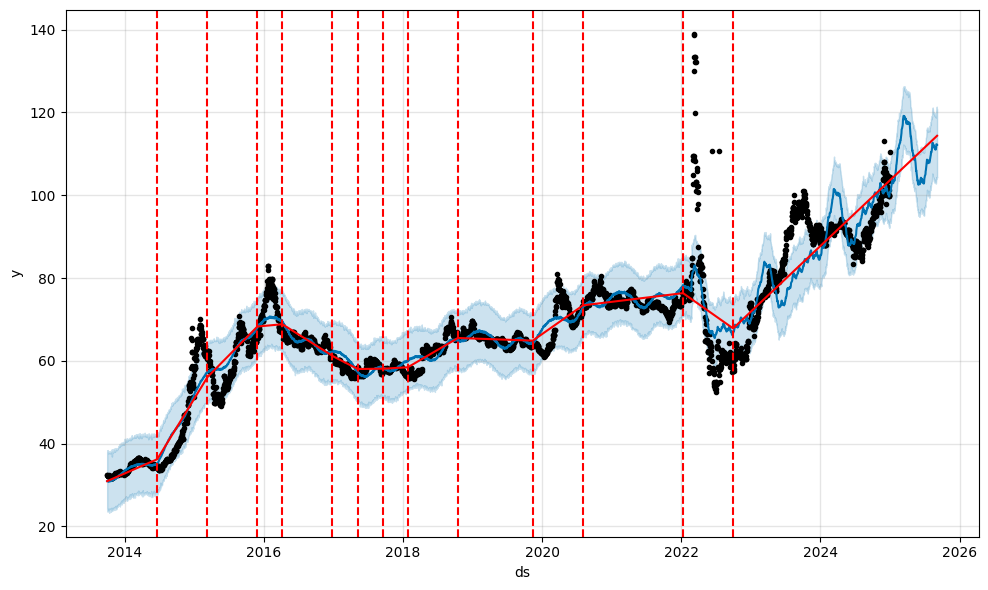

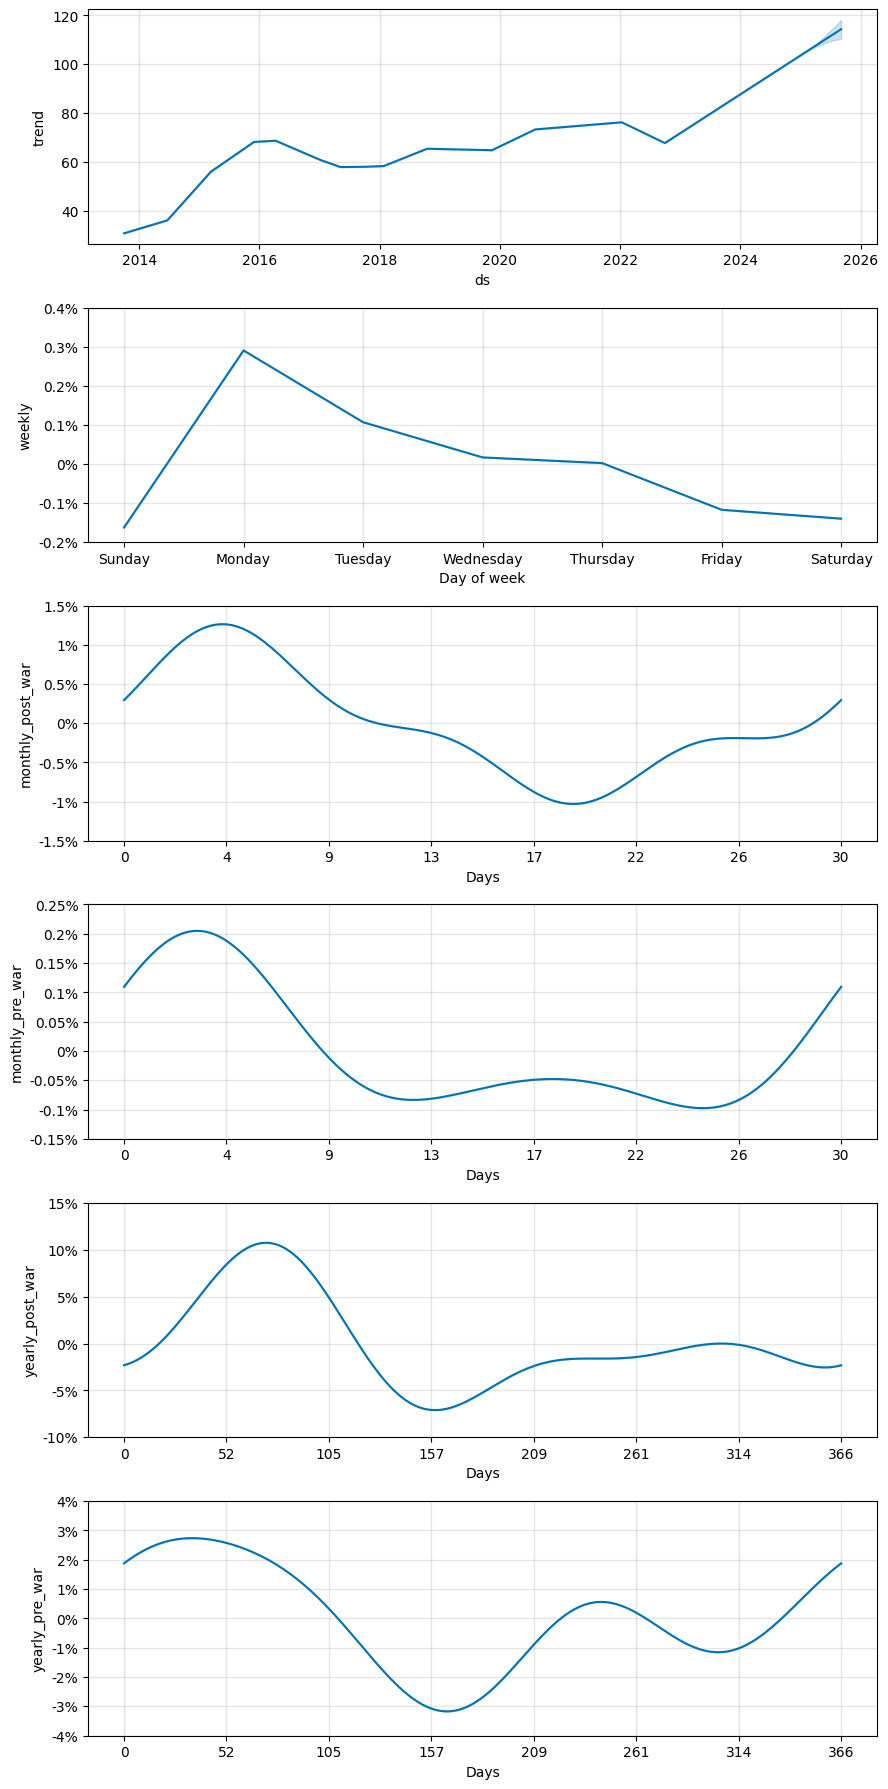

In [48]:
# Create future dataframe
future_m4 = m4.make_future_dataframe(periods=forecast_days)

# Add pre_war / post_war flags for future dates
cutoff_date = pd.to_datetime("2022-02-24")
future_m4['pre_war'] = (future_m4['ds'] < cutoff_date).astype(bool)
future_m4['post_war'] = (future_m4['ds'] >= cutoff_date).astype(bool)

# Make predictions
forecast_m4 = m4.predict(future_m4)

# Plot forecast
fig = m4.plot(forecast_m4)
a = add_changepoints_to_plot(fig.gca(), m4, forecast_m4)

fig = m4.plot_components(forecast_m4)

In [49]:
m4_result = evaluate_forecast(forecast_m4, test, forecast_days, model_name="m4")
m4_result

{'Model': 'm4',
 'MAE': 24.769075604383875,
 'MAPE': np.float64(30.072553860123968),
 'MSE': 699.3240743588927}

###### M5: Prophet with Economic Regressors

In [77]:
# Building the Prophet model
m5 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m5.add_country_holidays(country_name='RU')

# Add monthly seasonality
m5.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Add Regressor
m5.add_regressor('interest_rate')
m5.add_regressor('sanctions_count')
m5.add_regressor('oil_price')
m5.add_regressor('gold')
m5.add_regressor('palladium')
m5.add_regressor('platinum')
m5.add_regressor('silver')

m5.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/di79dd61.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/qeqn_iyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58825', 'data', 'file=/tmp/tmpic4nhgzq/di79dd61.json', 'init=/tmp/tmpic4nhgzq/qeqn_iyy.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_model8cnm_v8q/prophet_model-20250919073258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:33:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [78]:
# Create future dataframe
future_m5 = m5.make_future_dataframe(periods=forecast_days)
future_m5.tail()

# Create include regressors in future
future_regressors = df_prophet.drop(columns = ['ds', 'y', 'pre_war', 'post_war',
                                               'y_lag_1', 'y_lag_2', 'y_lag_3', 'y_lag_4',
                                               'y_lag_5', 'y_lag_6', 'y_lag_13'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)
future_regressors

# Concatenate future dataframe with future_regressors along axis 1 (columns)
future_m5 = pd.concat([future_m5, future_regressors], axis = 1)
future_m5.tail()

ds  oil_price         gold    palladium     platinum     silver  \
4354 2025-09-01  64.010002  3473.699951  1105.199951  1365.699951  40.200001   
4355 2025-09-02  65.589996  3549.399902  1136.400024  1405.800049  41.070999   
4356 2025-09-03  63.970001  3593.199951  1168.500000  1448.599976  41.542000   
4357 2025-09-04  63.480000  3565.800049  1125.500000  1371.199951  40.910999   
4358 2025-09-05  61.869999  3613.199951  1111.599976  1381.699951  41.074001   

      interest_rate  sanctions_count  
4354           18.0          25691.0  
4355           18.0          25691.0  
4356           18.0          25691.0  
4357           18.0          25691.0  
4358           18.0          25691.0

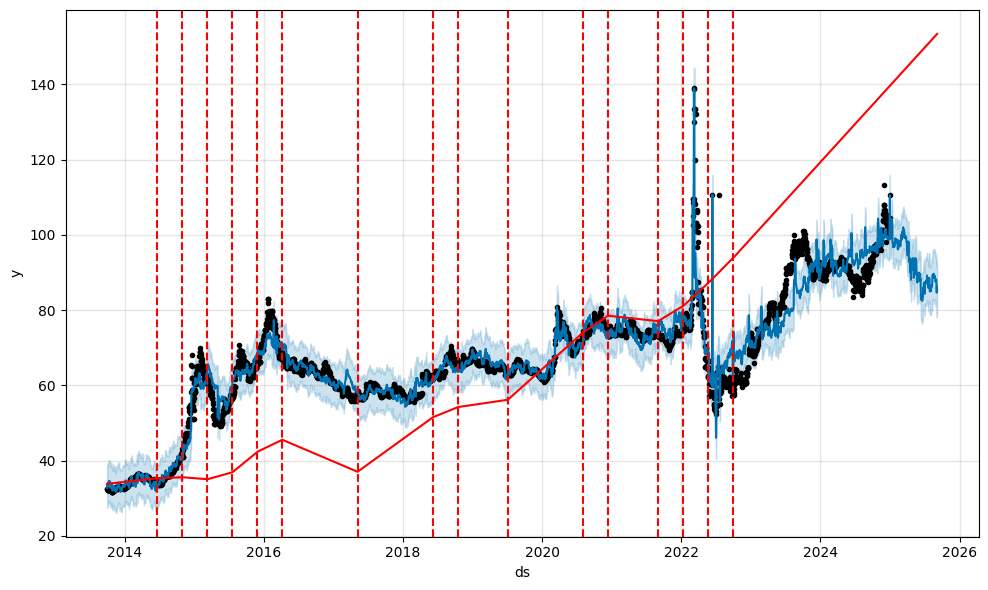

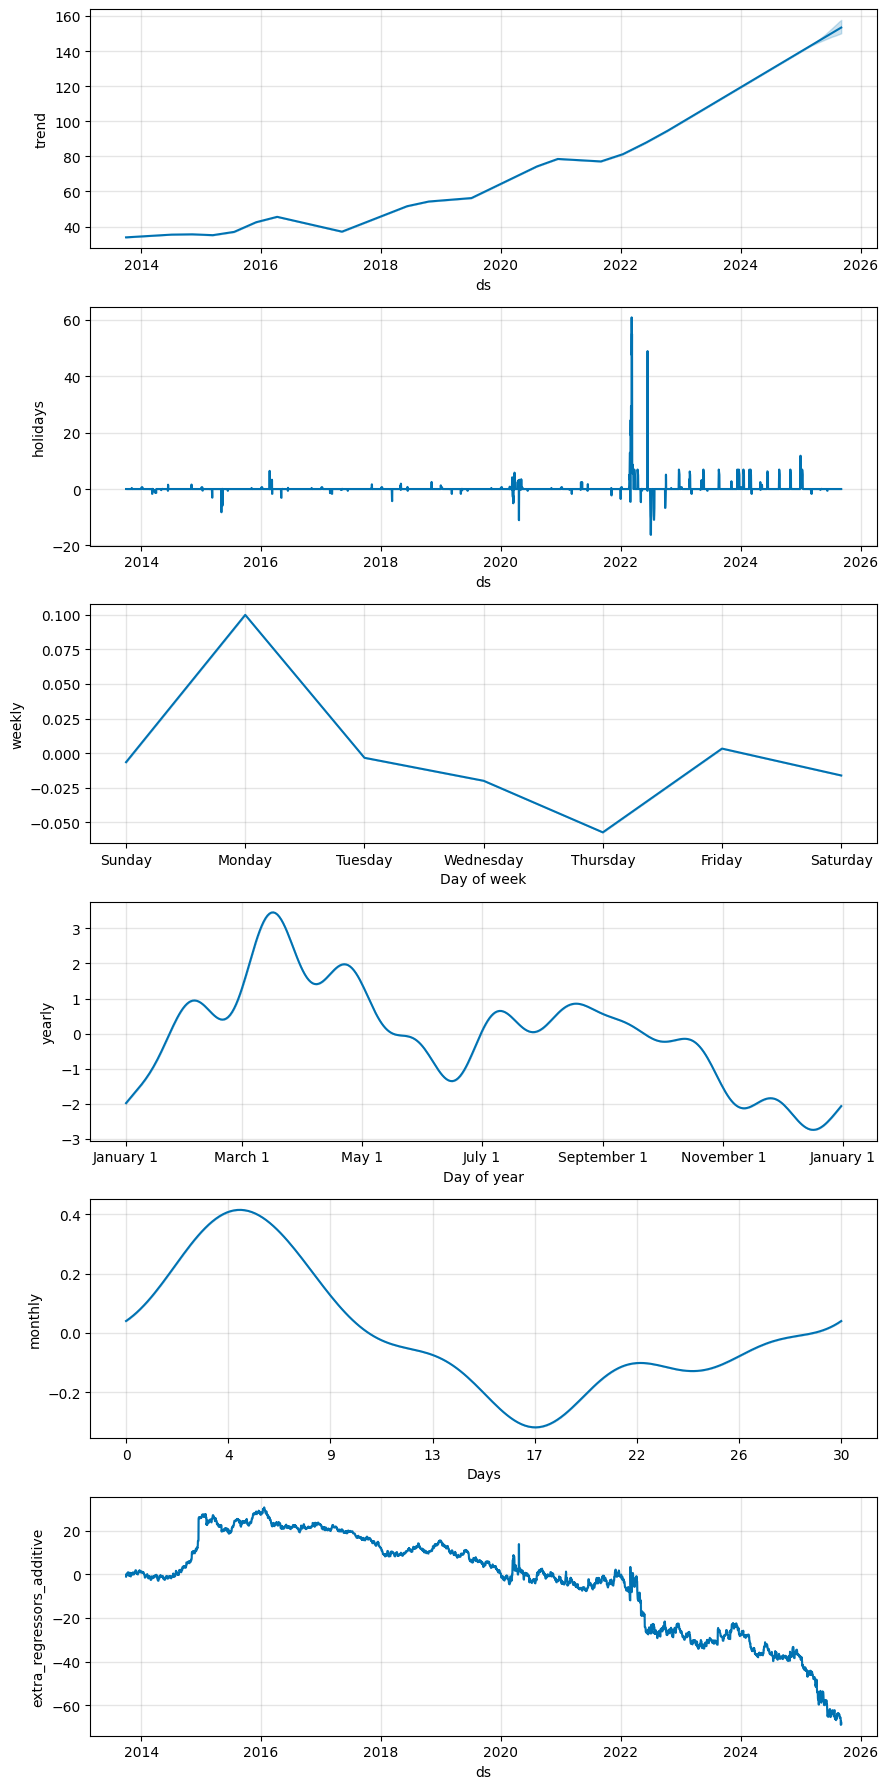

In [79]:
# Make predictions
forecast_m5 = m5.predict(future_m5)

# Plot forecast
fig = m5.plot(forecast_m5)
a = add_changepoints_to_plot(fig.gca(), m5, forecast_m5)

fig = m5.plot_components(forecast_m5)

In [81]:
m5_result = evaluate_forecast(forecast_m5, test, forecast_days, model_name="m5")
m5_result

{'Model': 'm5',
 'MAE': 8.388317223090663,
 'MAPE': np.float64(10.05636921015323),
 'MSE': 85.0529576669642}

In [72]:
# Regressor Coefficients
regressor_coefficients(m5)

regressor regressor_mode       center  coef_lower      coef  \
0    interest_rate       additive     9.351982    1.844660  1.844660   
1  sanctions_count       additive  5957.705181   -0.002804 -0.002804   
2        oil_price       additive    65.576529   -0.209919 -0.209919   
3             gold       additive  1565.508391   -0.034020 -0.034020   
4        palladium       additive  1304.849197   -0.002331 -0.002331   
5         platinum       additive  1007.681487   -0.016382 -0.016382   
6           silver       additive    20.006066    1.642494  1.642494   

   coef_upper  
0    1.844660  
1   -0.002804  
2   -0.209919  
3   -0.034020  
4   -0.002331  
5   -0.016382  
6    1.642494

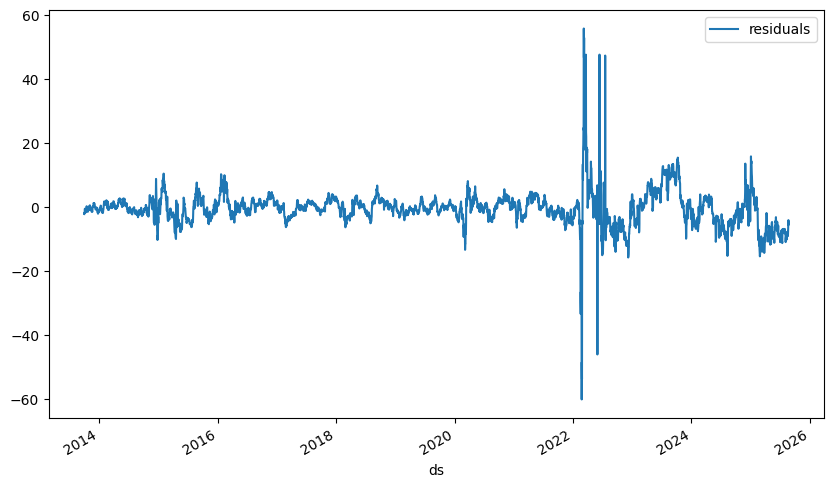

In [80]:
# plotting the residuals
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast_m5["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

###### M6: Prophet with Lagged Values

In [56]:
# Building the Prophet model
m6 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m6.add_country_holidays(country_name='RU')

# Add monthly seasonality
m6.add_seasonality(name='monthly', period=30.5, fourier_order=3)

# Add Lagged Values
m6.add_regressor('y_lag_1')
m6.add_regressor('y_lag_2')
m6.add_regressor('y_lag_3')
m6.add_regressor('y_lag_4')
m6.add_regressor('y_lag_5')
m6.add_regressor('y_lag_6')
m6.add_regressor('y_lag_13')

m6.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/g6mm8o_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/uke9srrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74372', 'data', 'file=/tmp/tmpic4nhgzq/g6mm8o_x.json', 'init=/tmp/tmpic4nhgzq/uke9srrh.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modelsudn6sh2/prophet_model-20250919072448.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:24:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:25:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
# Create future dataframe
future_m6 = m6.make_future_dataframe(periods=forecast_days)

# Create future regressors
future_regressors = df_prophet.drop(columns = ['ds', 'y', 'gold', 'palladium', 'platinum', 'silver', 'oil_price', 'interest_rate', 'sanctions_count'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)
future_regressors

# Concatenate future dataframe with future_regressors along axis 1 (columns)
future_m6 = pd.concat([future_m6, future_regressors], axis = 1)

future_m6.tail()

ds  pre_war  post_war    y_lag_1    y_lag_2    y_lag_3  \
4354 2025-09-01    False      True  80.496208  80.496208  80.496208   
4355 2025-09-02    False      True  78.898216  80.496208  80.496208   
4356 2025-09-03    False      True  80.573936  78.898216  80.496208   
4357 2025-09-04    False      True  80.547897  80.573936  78.898216   
4358 2025-09-05    False      True  80.997192  80.547897  80.573936   

        y_lag_4    y_lag_5    y_lag_6   y_lag_13  
4354  80.347900  80.494743  80.695786  80.490982  
4355  80.496208  80.347900  80.494743  80.771194  
4356  80.496208  80.496208  80.347900  80.496513  
4357  80.496208  80.496208  80.496208  80.579796  
4358  78.898216  80.496208  80.496208  80.579796

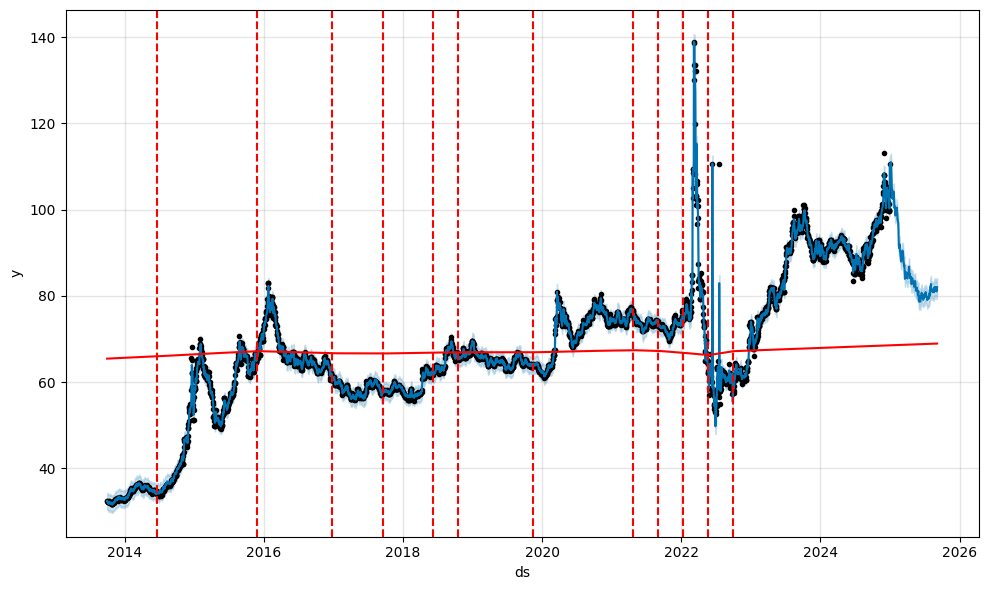

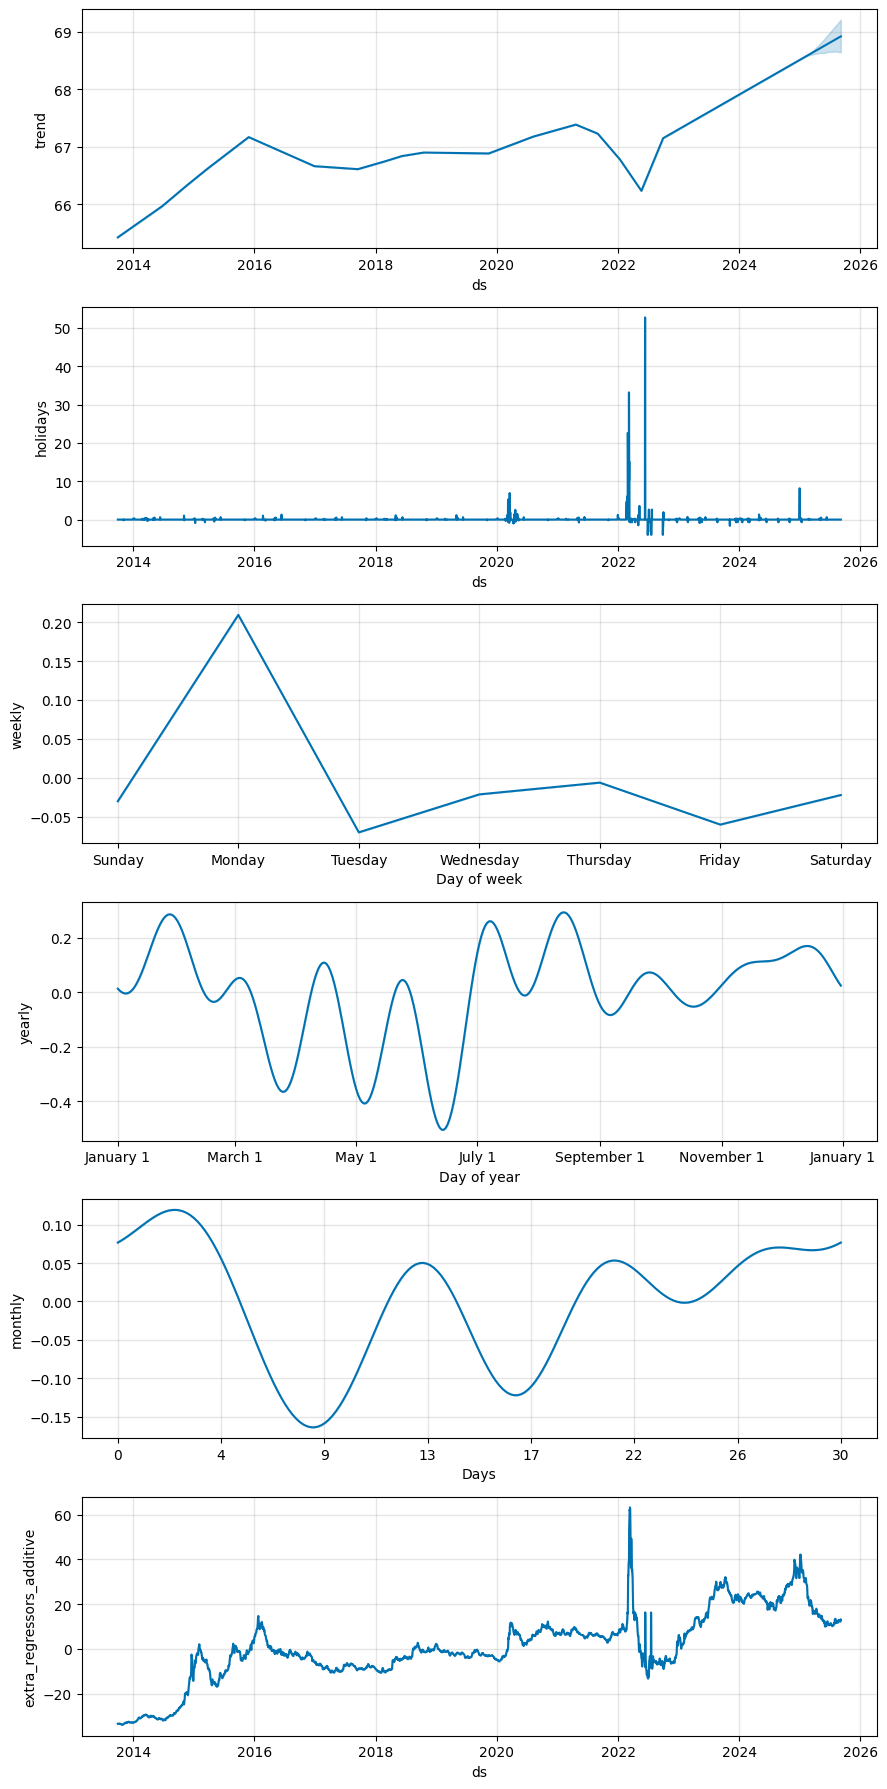

In [58]:
# Make predictions
forecast_m6 = m6.predict(future_m6)

# Plot forecast
fig = m6.plot(forecast_m6)
a = add_changepoints_to_plot(fig.gca(), m6, forecast_m6)

fig = m6.plot_components(forecast_m6)

In [59]:
m6_result = evaluate_forecast(forecast_m6, test, forecast_days, model_name="m6")
m6_result

{'Model': 'm6',
 'MAE': 1.358762410658417,
 'MAPE': np.float64(1.607332690168474),
 'MSE': 2.7285971475083795}

In [60]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m6)

regressor regressor_mode     center  coef_lower      coef  coef_upper
0   y_lag_1       additive  67.017778    0.467123  0.467123    0.467123
1   y_lag_2       additive  67.000205    0.255991  0.255991    0.255991
2   y_lag_3       additive  66.983790    0.081554  0.081554    0.081554
3   y_lag_4       additive  66.967327    0.061805  0.061805    0.061805
4   y_lag_5       additive  66.950805    0.027534  0.027534    0.027534
5   y_lag_6       additive  66.934217    0.030324  0.030324    0.030324
6  y_lag_13       additive  66.813768    0.035522  0.035522    0.035522

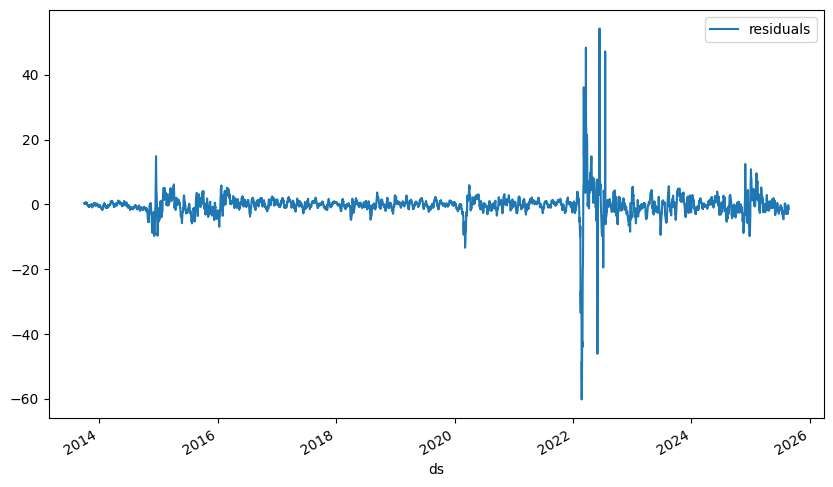

In [61]:
# plotting the residuals
df_residuals = pd.DataFrame({"ds": df_prophet["ds"], "residuals": df_prophet["y"] - forecast_m6["yhat"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(10, 6))

###### m7: Final Model

In [91]:
# Building the Prophet model
m7 = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m7.add_country_holidays(country_name='RU')

# Add monthly seasonality
m7.add_seasonality(name='monthly', period=30.5, fourier_order=3)

# Add Lagged Values
m7.add_regressor('y_lag_1')
m7.add_regressor('y_lag_2')
m7.add_regressor('y_lag_3')
m7.add_regressor('interest_rate')

m7.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/1ky5hvwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/93dv_18j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76387', 'data', 'file=/tmp/tmpic4nhgzq/1ky5hvwi.json', 'init=/tmp/tmpic4nhgzq/93dv_18j.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modeljni8dful/prophet_model-20250919075428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:54:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:54:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [92]:
# Create future dataframe
future_m7 = m7.make_future_dataframe(periods=forecast_days)

# Create future regressors
future_regressors = df_prophet.drop(columns = ['ds', 'y', 'gold', 'palladium', 'platinum', 'silver', 'oil_price', 'sanctions_count',
                                               'y_lag_4', 'y_lag_5', 'y_lag_6', 'y_lag_13',
                                               'pre_war', 'post_war'])
# Drop rows with missing values (NaNs) from future_regressors
future_regressors = future_regressors.dropna()
# Reset the index
future_regressors.reset_index(drop = True, inplace = True)
future_regressors

# Concatenate future dataframe with future_regressors along axis 1 (columns)
future_m7 = pd.concat([future_m7, future_regressors], axis = 1)

future_m7.tail()

ds  interest_rate    y_lag_1    y_lag_2    y_lag_3
4354 2025-09-01           18.0  80.496208  80.496208  80.496208
4355 2025-09-02           18.0  78.898216  80.496208  80.496208
4356 2025-09-03           18.0  80.573936  78.898216  80.496208
4357 2025-09-04           18.0  80.547897  80.573936  78.898216
4358 2025-09-05           18.0  80.997192  80.547897  80.573936

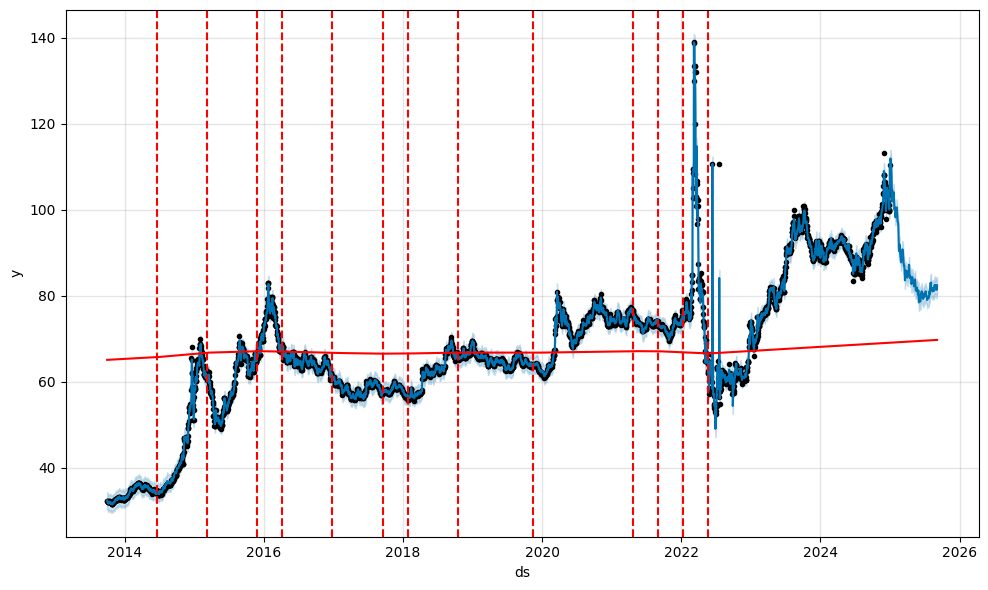

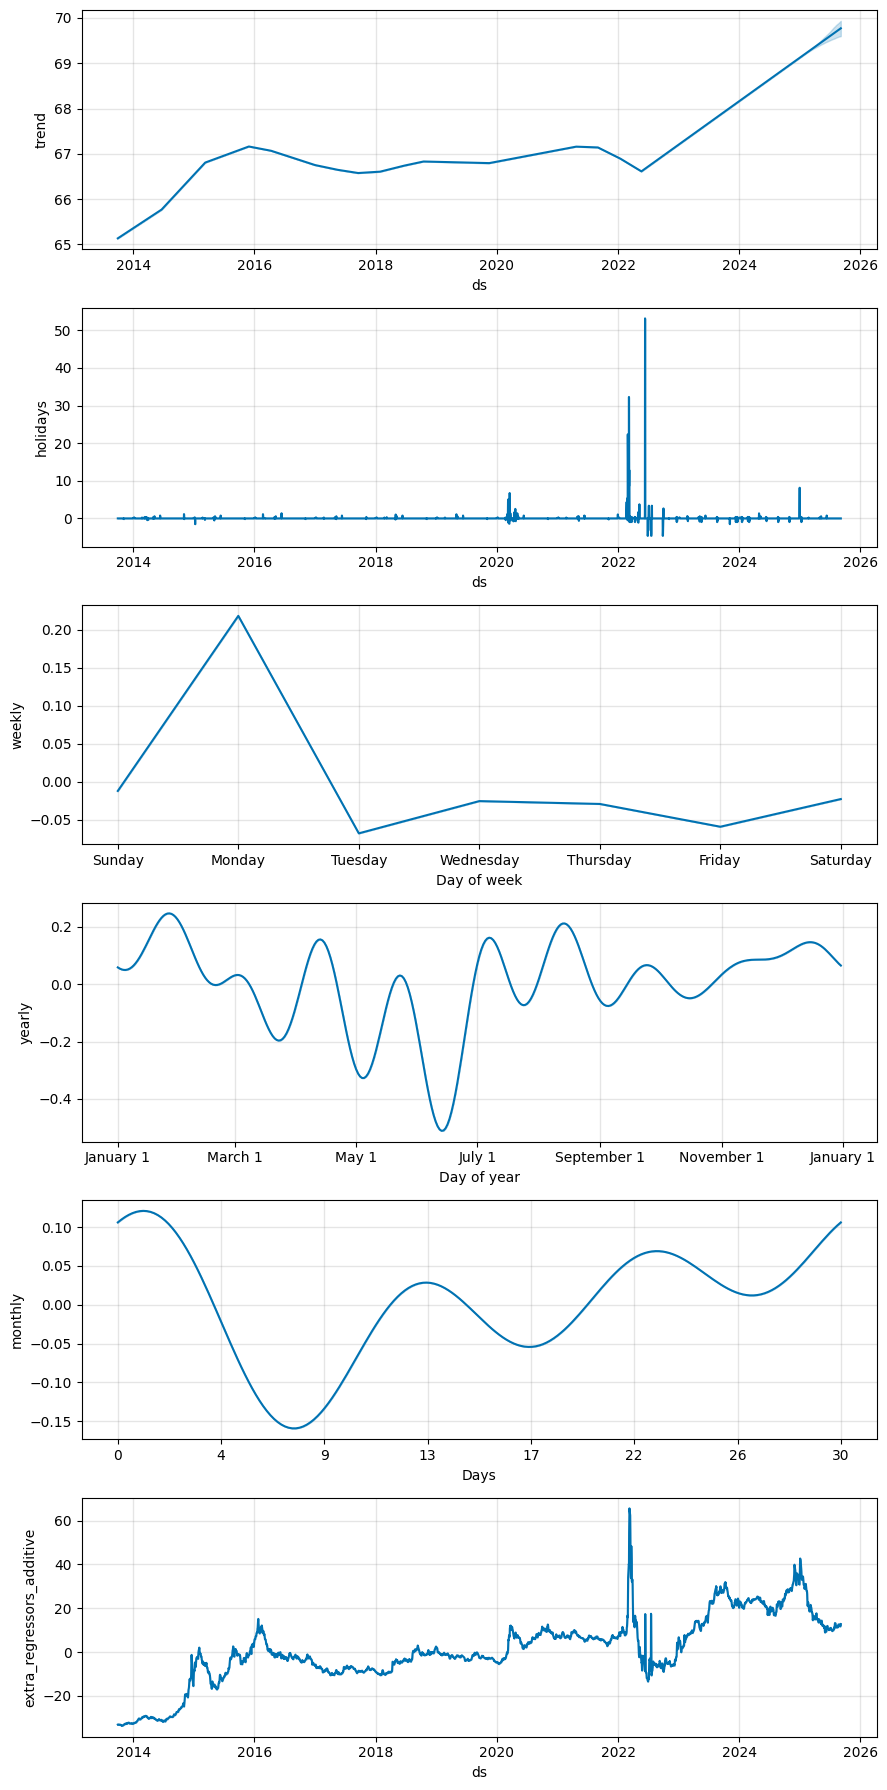

In [93]:
# Make predictions
forecast_m7 = m7.predict(future_m7)

# Plot forecast
fig = m7.plot(forecast_m7)
a = add_changepoints_to_plot(fig.gca(), m7, forecast_m7)

fig = m7.plot_components(forecast_m7)

In [94]:
m7_result = evaluate_forecast(forecast_m7, test, forecast_days, model_name="m7")
m7_result

{'Model': 'm7',
 'MAE': 1.4671109921688321,
 'MAPE': np.float64(1.7462792907310631),
 'MSE': 3.0186016816816212}

#### Model Evaluation

To evaluate the performance of different Prophet models, we adopted an incremental approach, gradually increasing model complexity and incorporating additional features. Each model was assessed using Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Mean Squared Error (MSE) on the test set, complemented by residual diagnostics and component analysis.

- M1: Baseline Prophet Model
The initial model included only trend, seasonality, and changepoints. While it provided a structural benchmark, error metrics were high, and residual plots revealed systematic patterns left unexplained—indicating the model’s inability to fully capture exchange rate volatility.

- M2: Prophet with Holidays and Major Events
Incorporating global and domestic shocks (COVID-19 outbreak, 2014 Crimea invasion, 2020 OPEC oil deal, and the 2022 Ukraine invasion) alongside built-in holiday effects improved interpretability. Holiday components appeared in the decomposition plots, confirming sensitivity to shocks. However, errors remained elevated, suggesting that exogenous shocks alone were insufficient for robust forecasting.

- M3: Prophet with Holidays, Events, and Sanctions
A sanctions count feature was engineered by detecting significant deviations (mean ± 1.5 standard deviations) in sanctions-related data. Adding this regressor captured sudden currency drops and spikes, but while qualitatively meaningful, improvements in error metrics were modest.

- M4: Prophet with Custom Seasonality
Custom seasonalities were introduced to account for regime shifts, particularly after the 2022 Ukraine invasion. Component plots confirmed noticeable changes in monthly and yearly seasonality. Despite aligning with intuition, these adjustments did not yield material improvements in MAE, MAPE, or MSE.

- M5: Prophet with Economic Regressors
Macroeconomic indicators (interest rates, oil, and precious metals) were added as regressors. Coefficient estimates highlighted interest rates and silver as significant predictors. This model substantially reduced forecast errors, demonstrating the explanatory power of economic fundamentals. Given forecast horizon constraints, only interest rates were retained in the final specification.

- M6: Prophet with Lagged Values
Autoregressive features were introduced by including lagged values (lags 1–6 and 13) based on the Partial Autocorrelation Function (PACF). Coefficients revealed that lags 1–3 carried the strongest predictive weight, effectively capturing short-term dependencies.

---

Final Model

The most accurate specification combined event-driven factors, economic regressors, and autoregressive components.
Cross-validation was conducted using a rolling window approach with the following parameters:

- period   = '30 days'   
- initial  = '730 days'  
- horizon  = '90 days'

| Parameter                 | Value          |
| ------------------------- | -------------- |
| period                    | 30 days        |
| intial                    | 730 days       |
| horizon                   | 90 days        |

This approach allowed for robust evaluation across multiple folds while avoiding overlap between training and test segments.

The final hybrid model achieved:

| Metric                    | Score          |
| ------------------------- | -------------- |
| MAE                       | 0.77        |
| MAPE                      | 1 %       |
| MSE                       | 4.77        |

---

Hyperparameter Optimization

To further refine performance, we applied Optuna for hyperparameter tuning. The best parameters identified are summarized below:

| Parameter                 | Value          |
| ------------------------- | -------------- |
| changepoint\_prior\_scale | 0.01           |
| seasonality\_prior\_scale | 5              |
| holidays\_prior\_scale    | 10             |
| seasonality\_mode         | multiplicative |
| use\_lag1                 | True           |
| use\_lag2                 | True           |
| use\_lag3                 | False          |
| use\_interest\_rate       | False          |
| monthly\_fourier          | 5              |
| yearly\_fourier           | 5              |

---

Final Forecast

After identifying the best parameters, the final model was refitted on the full dataset and used to generate a 120-day forecast horizon. This output serves as the primary predictive reference for analyzing future USD/RUB exchange rate dynamics.


In [67]:
results = []

results.append(evaluate_forecast(forecast_m1, test, forecast_days, "m1: Prophet Baseline"))
results.append(evaluate_forecast(forecast_m2, test, forecast_days, "m2: Prophet with Holidays/Events"))
results.append(evaluate_forecast(forecast_m3, test, forecast_days, "m3: Sanctions as Events"))
results.append(evaluate_forecast(forecast_m4, test, forecast_days, "m4: Prophet with Custom Seasonality"))
results.append(evaluate_forecast(forecast_m5, test, forecast_days, "m5: Prophet with Economic Regressors"))
results.append(evaluate_forecast(forecast_m6, test, forecast_days, "m6: Prophet with Lagged Values"))
results.append(evaluate_forecast(forecast_m7, test, forecast_days, "m7: Final Model"))

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)

Model        MAE       MAPE         MSE
0                  m1: Prophet Baseline  23.819304  29.091363  651.263170
1      m2: Prophet with Holidays/Events  23.763557  29.038937  650.362192
2               m3: Sanctions as Events  23.413410  28.601166  629.792085
3   m4: Prophet with Custom Seasonality  24.769076  30.072554  699.324074
4  m5: Prophet with Economic Regressors   8.388317  10.056369   85.052958
5        m6: Prophet with Lagged Values   1.358762   1.607333    2.728597
6                       m7: Final Model   1.469106   1.748615    3.025106

##### Cross Validation

In [86]:
period =  '30 days'      # Step size between cutoff dates period should always be less than horizon to avoid overlapping
initial = '730 days'    # Size of initial training period
horizon = '90 days'    # Forecast horizon

In [87]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=True,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="additive",
    seasonality_prior_scale=10,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.05 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m.add_country_holidays(country_name='RU')

# Add monthly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=3)


# Add Lagged Values
m.add_regressor('y_lag_1')
m.add_regressor('y_lag_2')
m.add_regressor('y_lag_3')
m.add_regressor('interest_rate')

m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/9ab7bj83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/3fwgg75n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64304', 'data', 'file=/tmp/tmpic4nhgzq/9ab7bj83.json', 'init=/tmp/tmpic4nhgzq/3fwgg75n.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_model6v90u4dk/prophet_model-20250919074248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:43:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [88]:
# Apply the CV to the model
df_cv = cross_validation(model = m, period = period, initial = initial, horizon = horizon, parallel = 'processes')

INFO:prophet:Making 118 forecasts with cutoffs between 2015-10-28 00:00:00 and 2025-06-07 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7a854adc8530>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/xbdvmx_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/tdh20lin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/tfjsibhg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/l7j91trt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46710', 'data', 'file=/tmp/tmpic4nhgzq/tdh20lin.json', 'init=/tmp/tmpic4nhgzq/l7j91trt.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_model9xolo5iz/prophet_model-20250919074314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:CmdStan arg

In [89]:
performance_metrics(df_cv)

horizon        mse      rmse       mae      mape     mdape     smape  \
0   9 days   1.813477  1.346654  0.650970  0.008588  0.004718  0.008625   
1  10 days   1.706358  1.306277  0.635493  0.008361  0.004719  0.008400   
2  11 days   1.612952  1.270020  0.619312  0.008186  0.004761  0.008214   
3  12 days   1.565384  1.251153  0.609917  0.008103  0.004757  0.008132   
4  13 days   2.490236  1.578048  0.639942  0.008351  0.004772  0.008413   
..     ...        ...       ...       ...       ...       ...       ...   
77 86 days  10.654855  3.264178  0.947718  0.012359  0.006384  0.012276   
78 87 days  11.447772  3.383456  0.977816  0.012725  0.006398  0.012594   
79 88 days  11.399099  3.376255  0.980874  0.012787  0.006461  0.012652   
80 89 days   8.842608  2.973652  0.941348  0.012508  0.006725  0.012238   
81 90 days   7.411460  2.722400  0.915807  0.012038  0.006618  0.011936   

    coverage  
0   0.876648  
1   0.875706  
2   0.878531  
3   0.887006  
4   0.890772  
..       ...  
77  0.820151  
78  0.817326  
79  0.806026  
80  0.796610  
81  0.792844  

[82 rows x 8 columns]

In [90]:
df_p = performance_metrics(df_cv)

mae  = round(df_p['mae'].mean(), 2)
mape = round(df_p['mape'].mean() * 100, 2)  # %
mse  = round(df_p['mse'].mean(), 2)         # Mean Squared Error
rmse = round(df_p['rmse'].mean(), 2)        # Root Mean Squared Error

print(f"The MAE  is {mae}")
print(f"The MAPE is {mape} %")
print(f"The MSE  is {mse}")
print(f"The RMSE is {rmse}")


The MAE  is 0.77
The MAPE is 1.01 %
The MSE  is 4.77
The RMSE is 2.07


In [98]:
# Compute the Error / deviation
df_cv['deviation'] = df_cv['yhat'] - df_cv['y']
df_cv['deviation_%'] = (df_cv['yhat'] / df_cv['y'] - 1) *100
# Days with the highest percentage deviation
df_cv.sort_values(by = 'deviation_%', ascending = False).head(10)

ds        yhat  yhat_lower  yhat_upper           y     cutoff  \
7255 2022-07-19  101.202595  100.046504  102.383037   57.715000 2022-05-24   
7220 2022-06-14  101.058257   99.818826  102.226775   57.715000 2022-05-24   
7195 2022-07-19  100.897233   99.667588  102.055212   57.715000 2022-04-24   
7160 2022-06-14  100.769354   99.546744  101.935838   57.715000 2022-04-24   
7100 2022-06-14   96.926102   95.779113   98.032952   57.715000 2022-03-25   
7315 2022-07-19   86.680299   85.188904   88.080136   57.715000 2022-06-23   
7316 2022-07-20   72.921613   71.506795   74.426800   56.465000 2022-06-23   
7101 2022-06-15   72.743810   71.598328   73.886041   58.340000 2022-03-25   
7196 2022-07-20   70.382626   69.215140   71.646932   56.465000 2022-04-24   
6956 2022-03-22  132.569948  131.880314  133.276666  106.614998 2022-02-23   

      deviation  deviation_%  
7255  43.487595    75.348861  
7220  43.343257    75.098774  
7195  43.182233    74.819775  
7160  43.054354    74.598205  
7100  39.211102    67.939188  
7315  28.965298    50.186777  
7316  16.456613    29.144803  
7101  14.403810    24.689424  
7196  13.917626    24.648236  
6956  25.954950    24.344558

In [97]:
# Days with the lowest deviation
df_cv.sort_values(by = 'deviation', ascending = True).head(10)

ds        yhat  yhat_lower  yhat_upper           y     cutoff  \
7314 2022-07-18   58.254495   56.791874   59.702324  110.674103 2022-06-23   
7219 2022-06-13   58.446154   57.139606   59.563452  110.674103 2022-05-24   
7254 2022-07-18   58.754731   57.565850   59.965575  110.674103 2022-05-24   
7099 2022-06-13   58.755822   57.670727   59.994227  110.674103 2022-03-25   
7159 2022-06-13   58.821055   57.627592   60.059021  110.674103 2022-04-24   
7194 2022-07-18   59.065520   57.886700   60.159767  110.674103 2022-04-24   
6822 2022-03-08  108.272385  107.559525  108.945902  138.965103 2021-12-25   
6882 2022-03-08  108.350049  107.643604  109.049663  138.965103 2022-01-24   
6942 2022-03-08  108.385210  107.677666  109.067935  138.965103 2022-02-23   
6835 2022-03-21  102.542829  101.809623  103.216752  132.088699 2021-12-25   

      deviation  deviation_%  
7314 -52.419608   -47.363933  
7219 -52.227949   -47.190759  
7254 -51.919372   -46.911943  
7099 -51.918281   -46.910957  
7159 -51.853048   -46.852016  
7194 -51.608583   -46.631128  
6822 -30.692718   -22.086637  
6882 -30.615054   -22.030749  
6942 -30.579893   -22.005447  
6835 -29.545870   -22.368204

##### Hyperparameter Tuning

In [101]:
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Define objective function for Optuna
def objective(trial):
    # Hyperparameters (small grid)
    changepoint_prior_scale = trial.suggest_categorical('changepoint_prior_scale', [0.01, 0.05])
    seasonality_prior_scale = trial.suggest_categorical('seasonality_prior_scale', [5, 10])
    holidays_prior_scale = trial.suggest_categorical('holidays_prior_scale', [5, 10])
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    # Regressor toggles
    use_lag1 = trial.suggest_categorical('use_lag1', [True, False])
    use_lag2 = trial.suggest_categorical('use_lag2', [True, False])
    use_lag3 = trial.suggest_categorical('use_lag3', [True, False])
    use_ir   = trial.suggest_categorical('use_interest_rate', [True, False])

    # Seasonality Fourier orders
    monthly_fourier = trial.suggest_categorical('monthly_fourier', [3, 5])
    yearly_fourier  = trial.suggest_categorical('yearly_fourier', [3, 5])

    # Build Prophet model
    m = Prophet(
        yearly_seasonality=False,   # Disable default yearly seasonality
        weekly_seasonality=True,
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays=custom_holidays2,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_prior_scale=changepoint_prior_scale
    )

    # Add built-in RU holidays
    m.add_country_holidays(country_name='RU')

    # Add seasonalities
    m.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_fourier)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=monthly_fourier)

    # Conditionally add regressors
    if use_lag1:
        m.add_regressor('y_lag_1')
    if use_lag2:
        m.add_regressor('y_lag_2')
    if use_lag3:
        m.add_regressor('y_lag_3')
    if use_ir:
        m.add_regressor('interest_rate')

    # Fit model
    m.fit(df_prophet)

    # Cross-validation
    df_cv = cross_validation(
        model=m,
        period=period,
        initial=initial,
        horizon=horizon,
        parallel='processes'
    )

    # Performance metrics
    df_perf = performance_metrics(df_cv, rolling_window=1)
    return df_perf['mae'].values[0]   # minimize MAE

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, n_jobs=1)  # 25 trials is lightweight but effective

print("Best params:", study.best_trial.params)
print("Best MAE:", study.best_value)

Streaming output truncated to the last 5000 lines.
10:40:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:40:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/sk7o60sy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/vjhshz53.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12580', 'data', 'file=/tmp/tmpic4nhgzq/sk7o60sy.json', 'init=/tmp/tmpic4nhgzq/vjhshz53.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_model85t86sus/prophet_model-20250919104050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:40:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:40:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done proces

Best params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'use_lag1': True, 'use_lag2': True, 'use_lag3': False, 'use_interest_rate': False, 'monthly_fourier': 5, 'yearly_fourier': 5}
Best MAE: 0.68730839842304


In [102]:
print("Best Parameters:", study.best_params)
print("Best MAE:", study.best_value)


Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'use_lag1': True, 'use_lag2': True, 'use_lag3': False, 'use_interest_rate': False, 'monthly_fourier': 5, 'yearly_fourier': 5}
Best MAE: 0.68730839842304


Hyperparameter Tuning Result:

- Best Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5, 'holidays_prior_scale': 10, 'seasonality_mode': 'multiplicative', 'use_lag1': True, 'use_lag2': True, 'use_lag3': False, 'use_interest_rate': False, 'monthly_fourier': 5, 'yearly_fourier': 5}
- Best MAE: 0.68730839842304

In [103]:
best_params = {
    'changepoint_prior_scale': 0.01,
    'seasonality_prior_scale': 5,
    'holidays_prior_scale': 10,
    'seasonality_mode': 'multiplicative',
    'use_lag1': True,
    'use_lag2': True,
    'use_lag3': False,
    'use_interest_rate': False,
    'monthly_fourier': 5,
    'yearly_fourier': 5
}

# Convert to DataFrame for nice tabular display
params_df = pd.DataFrame(list(best_params.items()), columns=['Parameter', 'Value'])
params_df


Parameter           Value
0  changepoint_prior_scale            0.01
1  seasonality_prior_scale               5
2     holidays_prior_scale              10
3         seasonality_mode  multiplicative
4                 use_lag1            True
5                 use_lag2            True
6                 use_lag3           False
7        use_interest_rate           False
8          monthly_fourier               5
9           yearly_fourier               5

##### Forecasting

In [104]:
# Building the Prophet model
m = Prophet(
    yearly_seasonality=False,     # Include yearly seasonality
    weekly_seasonality=True,     # Include weekly seasonality
    seasonality_mode="multiplicative",
    seasonality_prior_scale=5,  # Increase flexibility of seasonality
    holidays = custom_holidays2,
    holidays_prior_scale=10,     # Increase impact of holidays
    changepoint_prior_scale=0.01 # Control flexibility in detecting trend changes
)

# Add built in country holidays
m.add_country_holidays(country_name='RU')

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_seasonality(name='yearly', period=365.25, fourier_order=5)



# Add Lagged Values
m.add_regressor('y_lag_1')
m.add_regressor('y_lag_2')

m.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/fgao_22r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpic4nhgzq/qklkm4fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76857', 'data', 'file=/tmp/tmpic4nhgzq/fgao_22r.json', 'init=/tmp/tmpic4nhgzq/qklkm4fa.json', 'output', 'file=/tmp/tmpic4nhgzq/prophet_modell_koo6ih/prophet_model-20250919111741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:17:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [112]:
# --- Iterative forecast ---
forecast_horizon = 120
last_known = df_prophet.copy()
future_rows = []

for i in range(1, forecast_horizon + 1):
    next_date = last_known['ds'].max() + pd.Timedelta(days=1)

    row = {
        'ds': next_date,
        'pre_war': False,
        'post_war': True,
        'y_lag_1': last_known['y'].iloc[-1],
        'y_lag_2': last_known['y'].iloc[-2] if len(last_known) > 1 else last_known['y'].iloc[-1]
    }

    row_df = pd.DataFrame([row])
    forecast_step = m.predict(row_df)

    # Ensure all required columns exist
    row['y'] = forecast_step.get('yhat', pd.Series([None])).iloc[0]
    row['yhat_lower'] = forecast_step.get('yhat_lower', pd.Series([row['y']])).iloc[0]
    row['yhat_upper'] = forecast_step.get('yhat_upper', pd.Series([row['y']])).iloc[0]

    future_rows.append(row)
    last_known = pd.concat([last_known, pd.DataFrame([row])], ignore_index=True)

df_forecast_full = pd.concat([df_prophet, pd.DataFrame(future_rows)], ignore_index=True)

# --- Plot forecast with uncertainty ---
plt.figure(figsize=(15,6))
plt.plot(df_prophet['ds'], df_prophet['y'], color='black', label='Actual')
plt.plot(df_forecast_full['ds'].iloc[-forecast_horizon:], df_forecast_full['y'].iloc[-forecast_horizon:], color='blue', label='Forecast')
plt.fill_between(df_forecast_full['ds'].iloc[-forecast_horizon:],
                 df_forecast_full['yhat_lower'].iloc[-forecast_horizon:],
                 df_forecast_full['yhat_upper'].iloc[-forecast_horizon:],
                 color='blue', alpha=0.2, label='Uncertainty Interval')
plt.axvline(x=df_prophet['ds'].max(), color='red', linestyle='--', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('y')
plt.title('Iterative Forecast (Lagged Regressors)')
plt.legend()
plt.grid(True)
plt.show()


In [114]:
df_forecast_full[df_forecast_full['ds'] > '2025-09-28'][['ds', 'y', 'yhat_lower', 'yhat_upper']]

ds          y  yhat_lower  yhat_upper
4382 2025-09-29  84.627913   82.698708   86.550877
4383 2025-09-30  84.611947   82.661794   86.695043
4384 2025-10-01  84.765542   82.767080   86.800801
4385 2025-10-02  84.905973   83.067380   86.867765
4386 2025-10-03  84.986177   82.977064   86.914916
...         ...        ...         ...         ...
4474 2025-12-30  92.623292   90.727053   94.603604
4475 2025-12-31  92.717300   90.751473   94.665301
4476 2026-01-01  92.834682   90.838845   94.836287
4477 2026-01-02  92.878342   91.023063   94.583427
4478 2026-01-03  93.019706   91.240384   94.886709

[97 rows x 4 columns]

In [116]:
# Save forecast subset to CSV in current working directory
df_forecast_full[df_forecast_full['ds'] > '2025-09-28'][['ds', 'y', 'yhat_lower', 'yhat_upper']] \
    .to_csv('forecast_results.csv', index=False)

print("Forecast saved as 'forecast_results.csv' in current directory.")

Forecast saved as 'forecast_results.csv' in current directory.


In [106]:
df_forecast_full[['ds', 'y', 'yhat_lower', 'yhat_upper', 'y_lag_1', 'y_lag_2']].tail(30)

ds          y  yhat_lower  yhat_upper    y_lag_1    y_lag_2
4449 2025-12-05  90.874835   88.926737   92.734578  90.807586  90.661028
4450 2025-12-06  91.016958   89.066524   92.892946  90.874835  90.807586
4451 2025-12-07  91.145910   89.254682   92.983404  91.016958  90.874835
4452 2025-12-08  91.451496   89.571662   93.445284  91.145910  91.016958
4453 2025-12-09  91.440033   89.580683   93.408705  91.451496  91.145910
4454 2025-12-10  91.596875   89.532850   93.525726  91.440033  91.451496
4455 2025-12-11  91.720844   89.808802   93.608495  91.596875  91.440033
4456 2025-12-12  91.751972   89.785233   93.605184  91.720844  91.596875
4457 2025-12-13  91.826149   89.934132   93.753992  91.751972  91.720844
4458 2025-12-14  91.835024   89.836112   93.682197  91.826149  91.751972
4459 2025-12-15  91.965431   90.147893   93.888593  91.835024  91.826149
4460 2025-12-16  91.750645   89.937615   93.755377  91.965431  91.835024
4461 2025-12-17  91.726619   89.768967   93.709479  91.750645  91.965431
4462 2025-12-18  91.743066   89.716635   93.715440  91.726619  91.750645
4463 2025-12-19  91.765795   89.802832   93.698314  91.743066  91.726619
4464 2025-12-20  91.920087   90.093280   93.958857  91.765795  91.743066
4465 2025-12-21  92.058859   90.222300   94.075526  91.920087  91.765795
4466 2025-12-22  92.321944   90.462425   94.370508  92.058859  91.920087
4467 2025-12-23  92.205594   90.192076   94.188484  92.321944  92.058859
4468 2025-12-24  92.227426   90.274557   94.214014  92.205594  92.321944
4469 2025-12-25  92.237558   90.348267   94.217291  92.227426  92.205594
4470 2025-12-26  92.217433   90.380195   94.287916  92.237558  92.227426
4471 2025-12-27  92.318501   90.542408   94.374807  92.217433  92.237558
4472 2025-12-28  92.422906   90.500892   94.394812  92.318501  92.217433
4473 2025-12-29  92.691600   90.664332   94.638149  92.422906  92.318501
4474 2025-12-30  92.623292   90.715179   94.458168  92.691600  92.422906
4475 2025-12-31  92.717300   90.770098   94.614926  92.623292  92.691600
4476 2026-01-01  92.834682   90.781293   94.806935  92.717300  92.623292
4477 2026-01-02  92.878342   90.899321   94.788878  92.834682  92.717300
4478 2026-01-03  93.019706   91.039145   94.835197  92.878342  92.834682

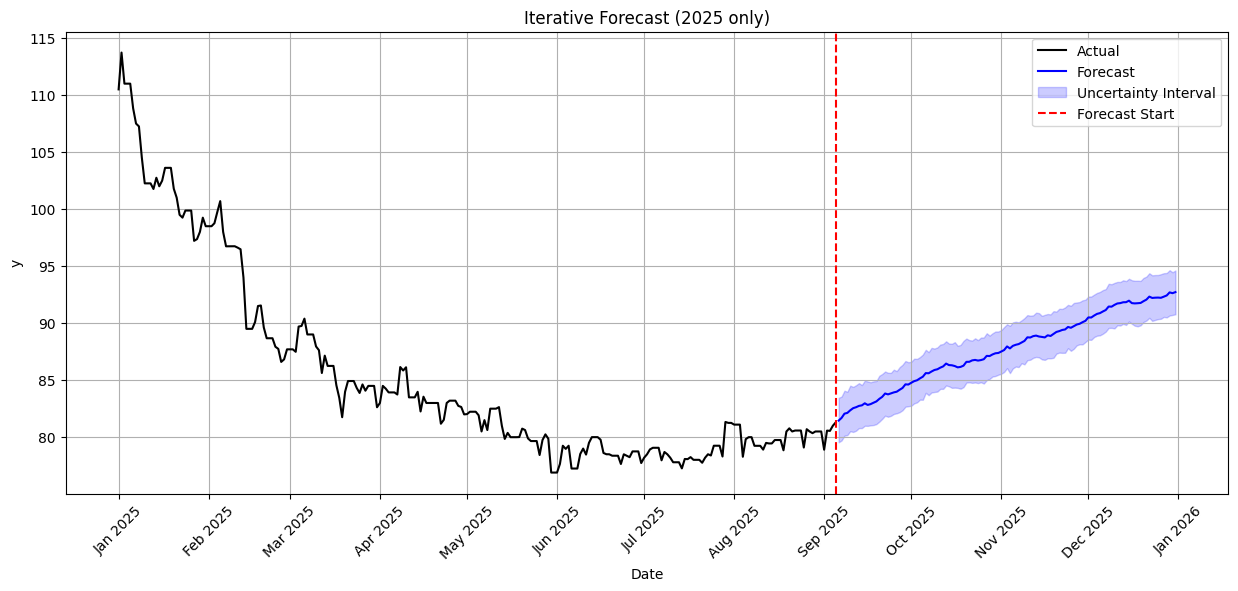

In [107]:
# --- Define date range for zoom ---
start_date = pd.to_datetime("2025-01-01")
end_date = pd.to_datetime("2025-12-31")

# --- Separate actual historical and forecast ---
actual_df = df_prophet[(df_prophet['ds'] >= start_date) &
                       (df_prophet['ds'] <= end_date)]

forecast_df = df_forecast_full[(df_forecast_full['ds'] > df_prophet['ds'].max()) &
                               (df_forecast_full['ds'] <= end_date)]

# --- Plot ---
plt.figure(figsize=(15,6))

# Actual historical values
plt.plot(actual_df['ds'], actual_df['y'], color='black', label='Actual')

# Forecasted values
plt.plot(forecast_df['ds'], forecast_df['y'], color='blue', label='Forecast')

# Uncertainty interval
plt.fill_between(forecast_df['ds'],
                 forecast_df['yhat_lower'],
                 forecast_df['yhat_upper'],
                 color='blue', alpha=0.2, label='Uncertainty Interval')

# Vertical line for forecast start
plt.axvline(x=df_prophet['ds'].max(), color='red', linestyle='--', label='Forecast Start')

plt.xlabel('Date')
plt.ylabel('y')
plt.title('Iterative Forecast (2025 only)')
plt.legend()
plt.grid(True)

# Format x-axis nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.show()



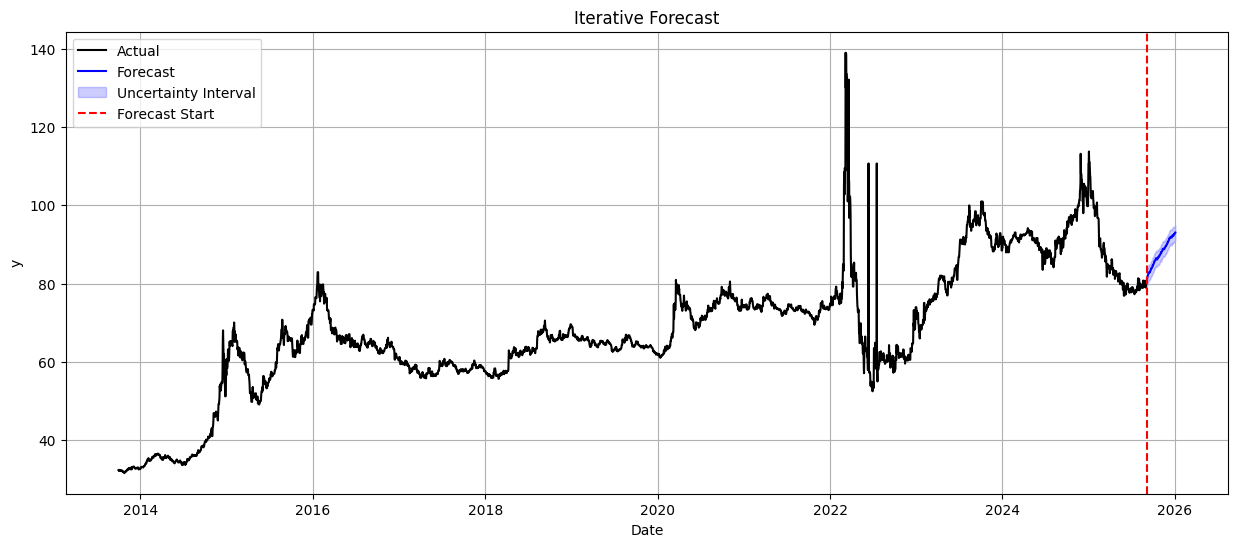

In [109]:
plt.figure(figsize=(15, 6))

# Actual historical
plt.plot(df_prophet['ds'], df_prophet['y'], color='black', label='Actual')

# Forecast
plt.plot(df_forecast_full['ds'].iloc[-forecast_horizon:],
         df_forecast_full['y'].iloc[-forecast_horizon:],
         color='blue', label='Forecast')

# Uncertainty interval
plt.fill_between(df_forecast_full['ds'].iloc[-forecast_horizon:],
                 df_forecast_full['yhat_lower'].iloc[-forecast_horizon:],
                 df_forecast_full['yhat_upper'].iloc[-forecast_horizon:],
                 color='blue', alpha=0.2, label='Uncertainty Interval')

# Forecast start vertical line
plt.axvline(x=df_prophet['ds'].max(), color='red', linestyle='--', label='Forecast Start')

plt.xlabel('Date')
plt.ylabel('y')
plt.title('Iterative Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
# --- 1) Make future dataframe including historical + forecast horizon ---
future = m.make_future_dataframe(periods=forecast_horizon, freq='D')

# Add regressors and flags to the future dataframe
future['pre_war'] = (future['ds'] < pd.to_datetime("2022-02-24")).astype(bool)
future['post_war'] = ~future['pre_war']

# Fill regressors for future horizon (iterative lagging not needed for components)
# We'll use the last known values (as you assumed interest_rate constant, lagged values as last y)
last_y = df_prophet['y'].iloc[-1]
last_y_lag1 = df_prophet['y_lag_1'].iloc[-1]
last_y_lag2 = df_prophet['y_lag_2'].iloc[-1]

future['y_lag_1'] = last_y_lag1
future['y_lag_2'] = last_y_lag2

# --- 2) Predict with Prophet ---
forecast_full = m.predict(future)

# --- 3) Plot components ---
from prophet.plot import plot_components_plotly, plot_components
fig = plot_components(m, forecast_full)



### END